In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, cos, sin
from datetime import datetime
import pandas as pd
import glob
import re
from matplotlib.pyplot import figure
from pymatgen.core.structure import Structure
from pymatgen.io.vasp import Poscar
from pymatgen.io.vasp.outputs import Outcar
from pymatgen.util.coord import get_angle
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')
homedir = os.path.expanduser('~')

In [2]:
def slurmlogindices(logfiles):
    n = []
    for file in logfiles:          
        temp = re.compile("slurm-([a-zA-Z]*)([0-9]+).out")
        res = temp.match(file).groups()
        n.append(int(res[1]))
        n.sort()
        
    return n


def read_dE(path):
    f = open(f'{path}', 'r')
    lines = f.readlines()
    f.close()
    
    dE = 0
    i = 0
    count = 0
    while i < len(lines):
        if 'F=' in lines[i]:
            count = i
        i = i + 1
        
    if 'OSZICAR' in path:
        match = re.search('[A-Z]+: *\d+ *-*\d+.\d+E*.\d+ *-*\d+.\d+E*.\d+', lines[count-1])
    else:
        match = re.search('[A-Z]+: *\d+ *-*\d+.\d+E*.\d+ *-*\d+.\d+E*.\d+', lines[count-3])
    dE = float(match.group(0).split()[3])
    return dE


def read_outcar(path):
    f = open(f'{path}', 'r')
    lines = f.readlines()
    f.close()
    
    for i in range(len(lines)):
        if 'FREE ENERGIE OF THE ION-ELECTRON SYSTEM (eV)' in lines[i]:
            l1 = lines[i+2]
            l2 = lines[i+4]
    
    # Tot free energy and energy w/o entropy
    f = float(l1.split()[4])
    ewe = float(l2.split()[3])
    return [f, ewe]


def get_lattice_consts(path):
    f= open(f'{path}', 'r')
    lines = f.readlines()
    f.close()
    
    return [float(lines[2].split()[0]), float(lines[3].split()[1]), float(lines[4].split()[2])]


def plot_convergence(oszicarfile):
    ocars = glob.glob(f'{oszicarfile}?')
    
    if len(ocars) > 0:
        ocars.sort()
    else:
        ocars.append(oszicarfile)
    
    globcount = 0 # ionic steps across all OSZICARs found
    finalenergiesglob = []
    globaldEs = []
    counts = []
    
    for ocar in ocars:
        f = open(ocar)
        lines = f.readlines()
        f.close()

        count = 0 # ionic steps
        finalenergies = []
        dEs = []
        for i in range(len(lines)):
            if "F= " in lines[i]:
                line = lines[i-1].split() # [i-1] for OSZICAR
                finalenergies.append(line[2])
                dEs.append(line[3])
                count += 1
                
                # increment globals
                finalenergiesglob.append(line[2])
                globaldEs.append(line[3])
                globcount += 1
    
        counts.append(count)
        finalenergies = np.array(finalenergies).astype('double')
        dEs = np.array(dEs).astype('double')
#         plot_energies(count, 0, finalenergies, dEs, False)
        
    print(f'ionic steps taken: {counts}')
    print(f'ionic steps, total: {globcount}')
    finalenergiesglob = np.array(finalenergiesglob).astype('double')
    globaldEs = np.array(globaldEs).astype('double')
    plot_energies(globcount, 0, finalenergiesglob, globaldEs, True)
    
    return count


def plot_energies(count, initstep, energies, dEs, plotdEs):
    # plot energy convergence (ionic and electronic steps)
    fig, ax = plt.subplots(figsize=(8,5))
    plt.rcParams.update({'font.size': 15})
    ax.plot(list(range(initstep+1, count+1)), energies[initstep:len(energies)])
    ax.ticklabel_format(useOffset=False)
    plt.ylabel('Energy (eV)')
    plt.title('Free total energy')
    plt.xlabel('Ionic step')
    plt.show()
    
    if plotdEs:
        fig, ax = plt.subplots(figsize=(8,5))
        plt.rcParams.update({'font.size': 15})
        ax.plot(list(range(count)), abs(dEs))
        ax.ticklabel_format(style='sci', useOffset=False)
        plt.ylabel('|dE| (eV)')
        plt.title(' Absolute Energy diff.')
        plt.xlabel('Electronic step')
        plt.show()


def check_slurmfile(sfile):
    f= open(f'{sfile}', 'r')
    lines = f.readlines()
    f.close()
    out = ""
    for i in range(len(lines)):
        if "reached required accuracy" in lines[i]:
            out = "Reached required accuracy for structural energy minimization"
        elif "please rerun with smaller EDIFF" in lines[i]:
            out = "Rerun with smaller EDIFF or continue from CONTCAR"
        elif "TIME LIMIT" in lines[i]:
            out = "Ran out of time!"
    return out


def maxforceselective(outcarfile):
    # Read OUTCAR file:
    ifile = open(outcarfile)  # r for reading

    maxi = 0
    maxpressure = 0
    toten = 0
    maxforce = -1
    maxdrift = 0
    selectivefile = 0
    print(" ", "Maxforce",  "atom#",  "Pressure", "Maxdrift", "TOTEN", sep='\t')

    while 1:
        efound = 0
        line = ifile.readline()
        ematch = re.search('energy  without entropy= +(-*\d+.\d+) + energy\(sigma->0\) =  +(-*\d+.\d+)', line)
        if ematch:
            toten= float(ematch.group(2))
            efound = 1
        elif re.search(r'external pressure', line):
            tmp,tmp,tmp,pressure,tmp,tmp,tmp,tmp,tmp,tmp = line.split()
            maxpressure = float(pressure)
        elif re.search(r'TOTAL\-FORCE', line):
            i=0
            line = ifile.readline()
            while 1:
                line = ifile.readline()
                if re.search(r'----', line):
                    line = ifile.readline()
                    a,b,driftx,drifty,driftz = line.split()
                    if abs(float(driftx)) > maxdrift:
                        maxdrift = abs(float(driftx))
                    if abs(float(drifty)) > maxdrift:
                        maxdrift = abs(float(drifty))
                    if abs(float(driftz)) > maxdrift:
                        maxdrift = abs(float(driftz))
                    break
                posx,posy,posz,forx,fory,forz = map(float, line.split())
                if selectivefile:
                    if (abs(forx) > maxforce) and (x[i] == 'T' or x[i] == 't'):
                        maxforce = abs(forx)
                        maxi = i
                    if (abs(fory) > maxforce) and (y[i] == 'T' or y[i] == 't'):
                        maxforce = abs(fory)
                        maxi = i
                    if (abs(forz) > maxforce) and (z[i] == 'T' or z[i] == 't'):
                        maxforce = abs(forz)
                        maxi = i
                else:
                    if abs(forx) > maxforce:
                        maxforce = abs(forx)
                        maxi = i
                    if abs(fory) > maxforce:
                        maxforce = abs(fory)
                        maxi = i
                    if abs(forz) > maxforce:
                        maxforce = abs(forz)
                        maxi = i
                i = i+1
        if efound:
            print(" ",  "{:0.5f}".format(maxforce), "  ", str(maxi+1), 
                  "{:0.2f}".format(maxpressure), " ",  "{:0.4f}".format(maxdrift), 
                  " ",  "{:0.8f}".format(toten), sep='\t')
            maxforce = 0
            maxdrift = 0
        if not line:
            break

In [3]:
def magmom(outcar_file):#, ions):

    f = open(outcar_file)
    lines = f.readlines()
    f.close()

    if ions == 64:
        Fepos = []
    Mnpos = [17, 25, 33]
    #atoms = 8
    countx = 0
    county = 0
    countz = 0
    for i in range(len(lines)):
        if "magnetization (x)" in lines[i]:
            countx = i
        elif "magnetization (y)" in lines[i]:
            county = i
        elif "magnetization (z)" in lines[i]:
            countz = i

    maglinesx = lines[countx:countx+46]
    maglinesy = lines[county:county+46]
    maglinesz = lines[countz:countz+46]

    magmom_x = np.array([])
    magmom_y = np.array([])
    magmom_z = np.array([])

    for line in maglinesx[4:len(maglinesx)-2]:
        line = line.split()
        if int(line[0]) >= Mnpos[0]:
            magmom_x = np.append(float(line[4]), magmom_x)
    magmom_x = np.flip(magmom_x)

    for line in maglinesy[4:len(maglinesy)-2]:
        line = line.split()
        if int(line[0]) >= Mnpos[0]:
            magmom_y = np.append(float(line[4]), magmom_y)
    magmom_y = np.flip(magmom_y)

    for line in maglinesz[4:len(maglinesz)-2]:
        line = line.split()
        if int(line[0]) >= Mnpos[0]:
            magmom_z = np.append(float(line[4]), magmom_z)
    magmom_z = np.flip(magmom_z)

    netmagmom = np.array([sum(magmom_x), sum(magmom_y), sum(magmom_z)])
    #print(netmagmom)
    scalar_magmom = np.sqrt(netmagmom[0]**2 + netmagmom[1]**2 + netmagmom[2]**2)
    print(f'Net scalar mag mom: {scalar_magmom}')

    return netmagmom, scalar_magmom

-82.06499758
[-50 -40 -30 -20 -10  10  20  30  40  50]
-50
Last job was 6021408
dE reached -3.0923e-10
Reached required accuracy for structural energy minimization
ionic steps taken: [14, 42, 1]
ionic steps, total: 57


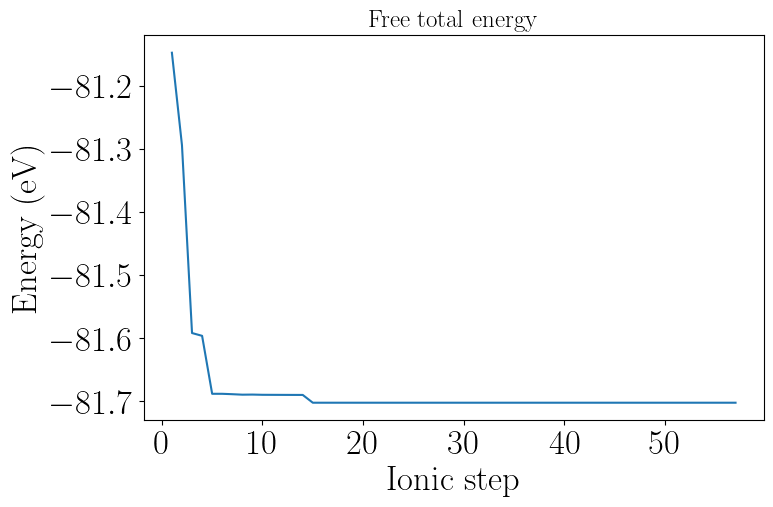

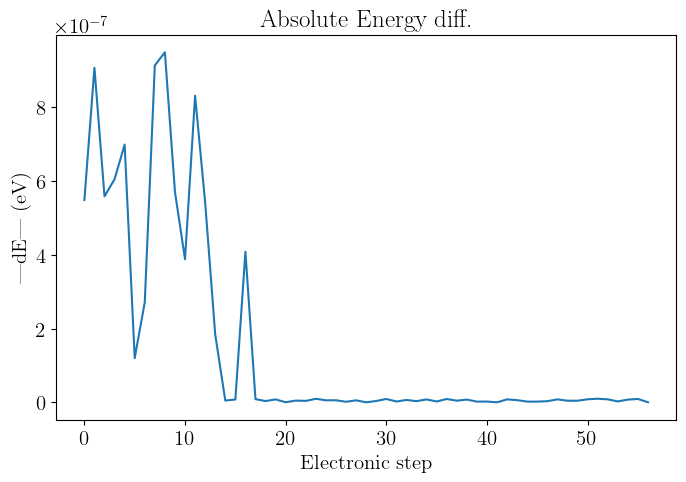

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	9	26.20	 	0.0000	 	-81.70220201
-40
Last job was 6020624
dE reached 5.0059e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [13, 49, 1]
ionic steps, total: 63


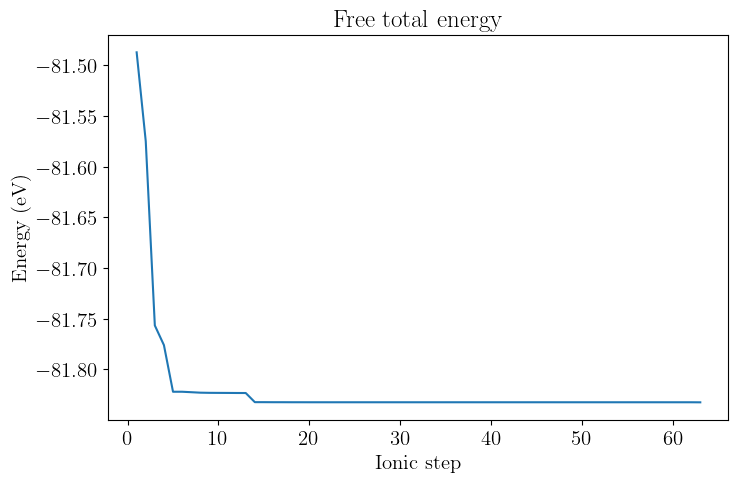

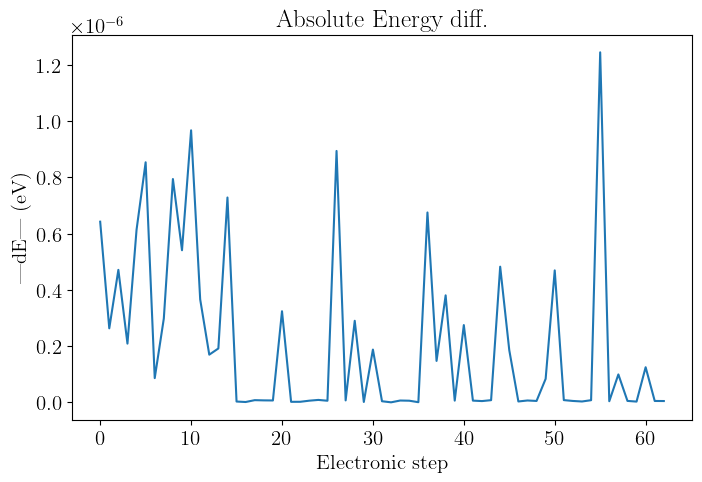

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	9	20.99	 	0.0000	 	-81.83241997
-30
Last job was 6020625
dE reached 4.4092e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [10, 38, 1]
ionic steps, total: 49


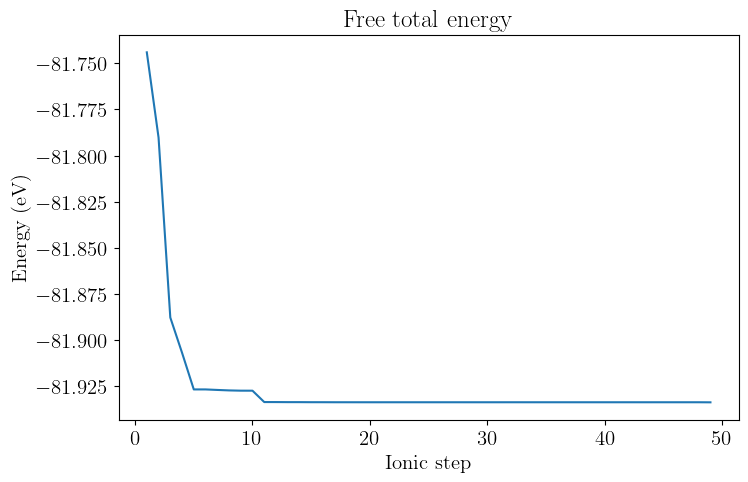

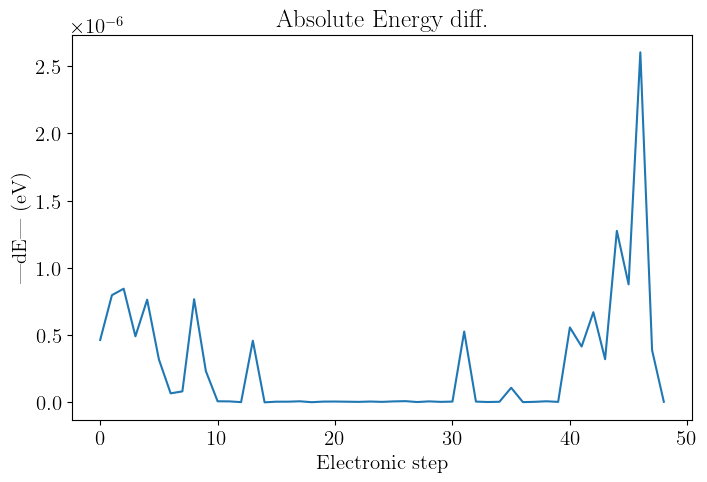

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	9	15.80	 	0.0000	 	-81.93360915
-20
Last job was 6020626
dE reached -5.4315e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [8, 54, 1]
ionic steps, total: 63


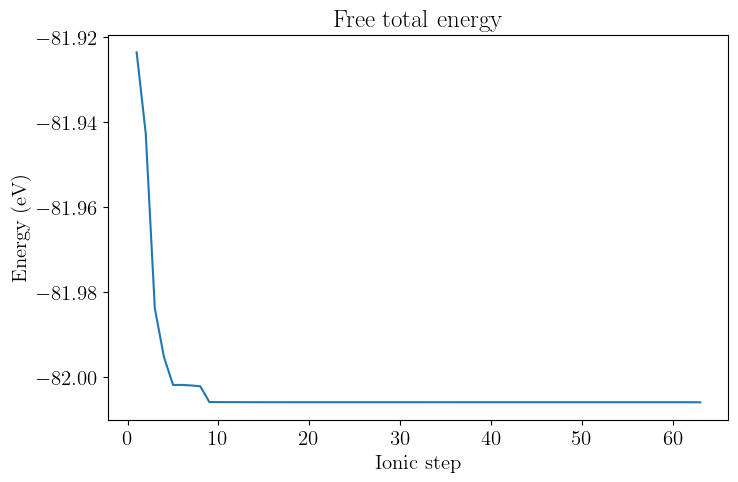

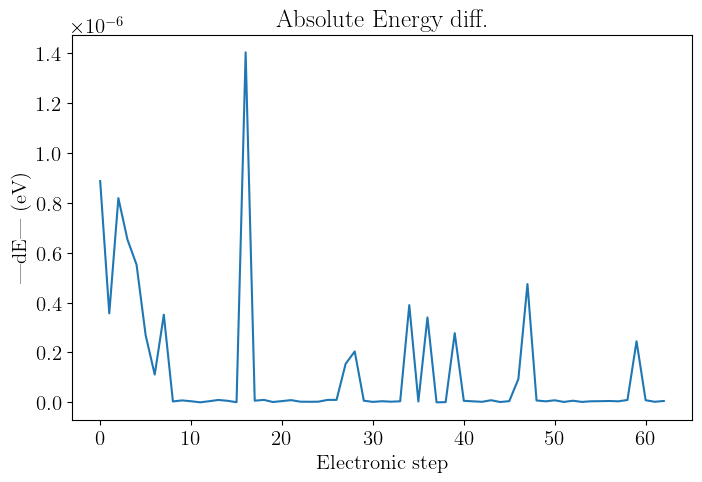

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	9	10.58	 	0.0000	 	-82.00590674
-10
Last job was 6022167
dE reached -9.2587e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [7, 50, 1]
ionic steps, total: 58


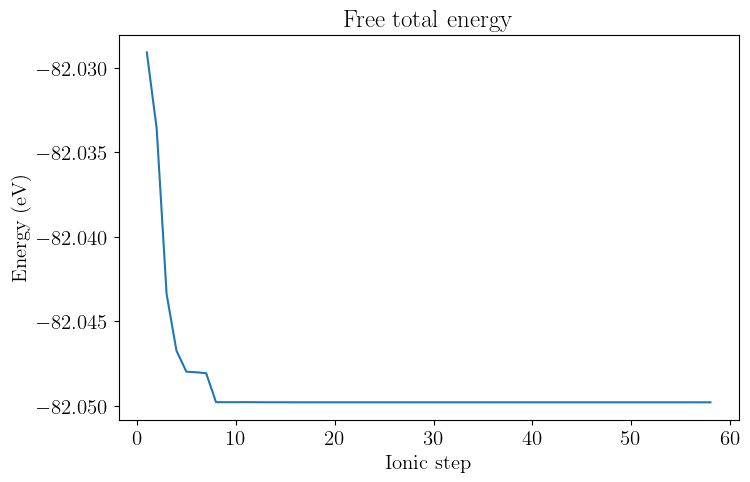

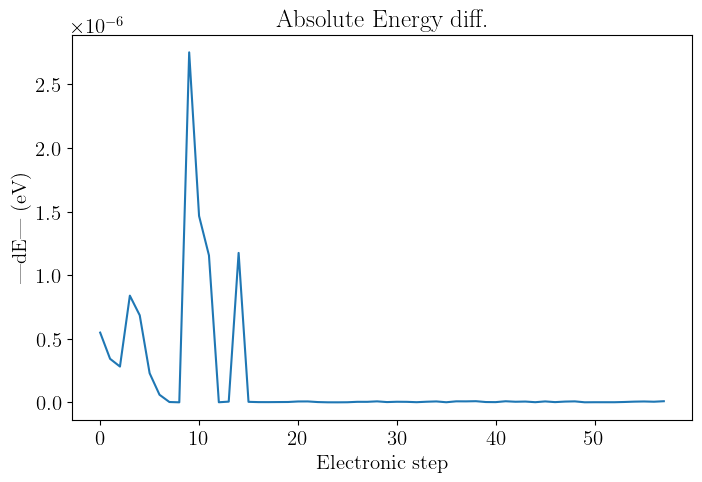

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00046	  	13	5.32	 	0.0004	 	-82.04978326
10
Last job was 6020628
dE reached -9.4697e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [7, 39, 1]
ionic steps, total: 47


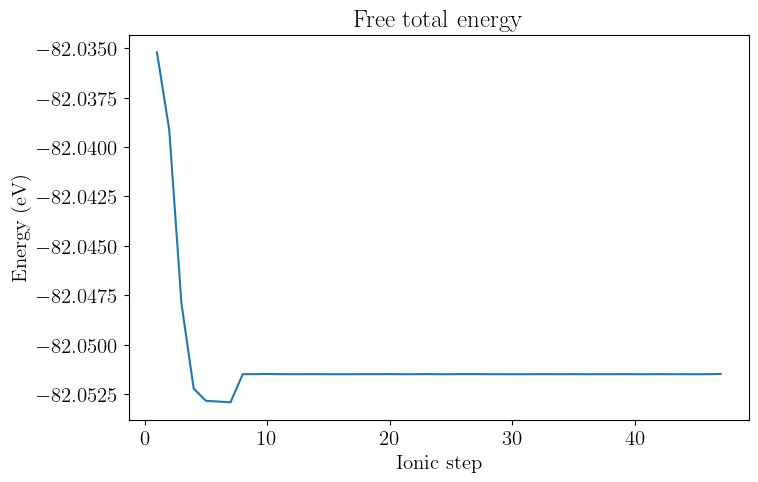

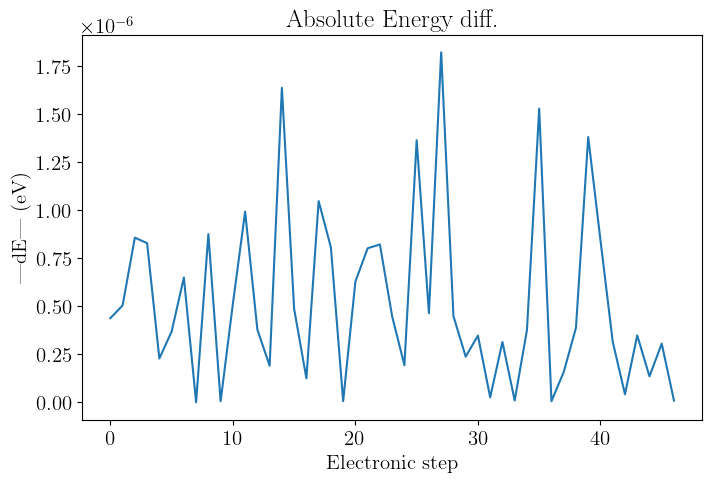

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	9	-5.32	 	0.0000	 	-82.05148063
20
Last job was 6020629
dE reached -6.4829e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [7, 41, 1]
ionic steps, total: 49


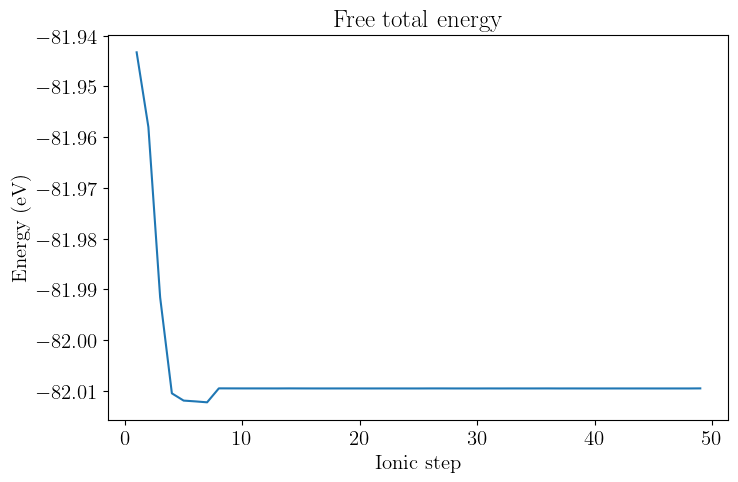

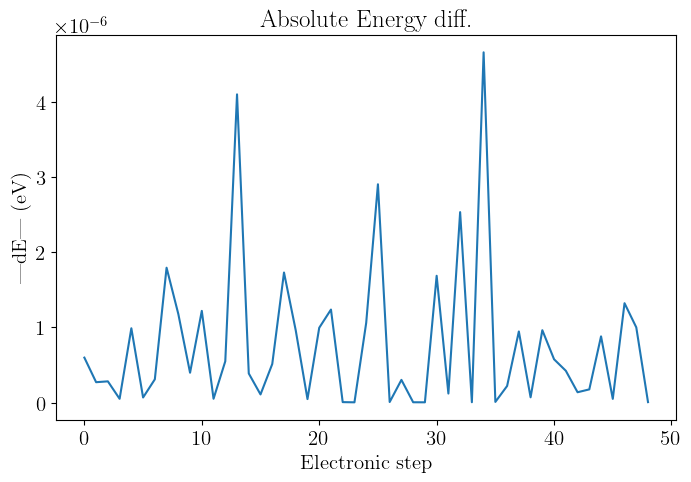

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	13	-10.55	 	0.0000	 	-82.00950666
30
Last job was 6021396
dE reached -8.9385e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [7, 42, 1]
ionic steps, total: 50


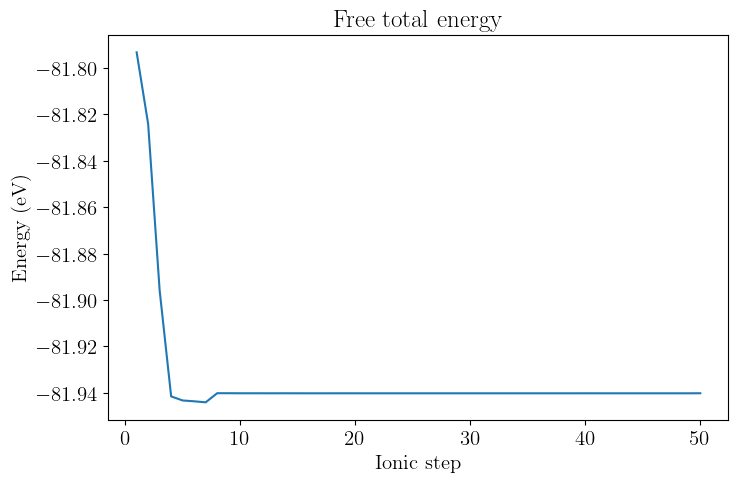

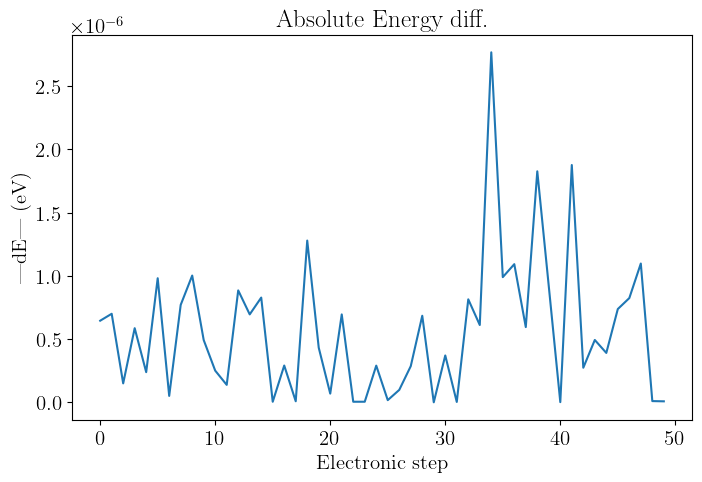

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	9	-15.65	 	0.0000	 	-81.94017443
40
Last job was 6020631
dE reached -8.8294e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [7, 34, 1]
ionic steps, total: 42


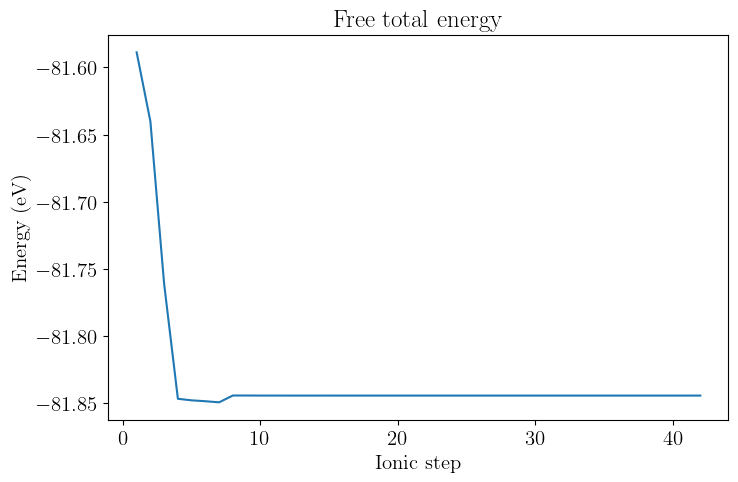

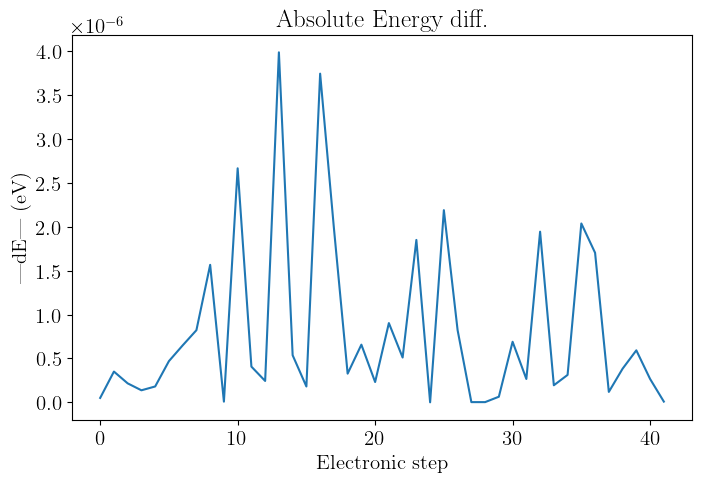

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	13	-20.65	 	0.0000	 	-81.84420120
50
Last job was 6020632
dE reached -8.1782e-09
Reached required accuracy for structural energy minimization
ionic steps taken: [8, 45, 1]
ionic steps, total: 54


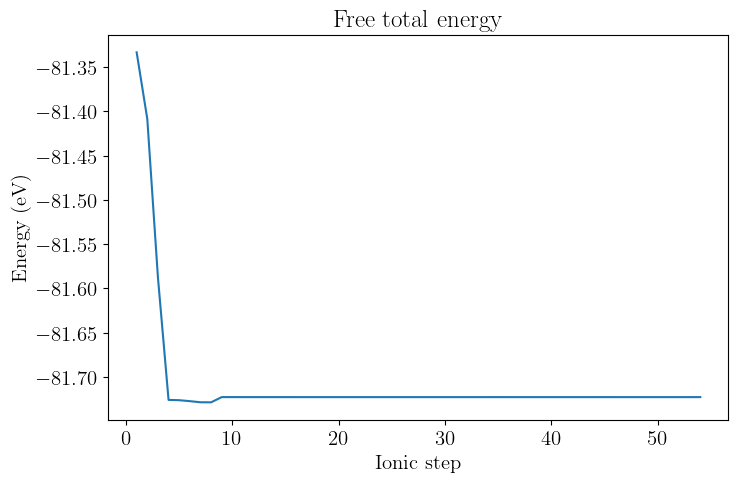

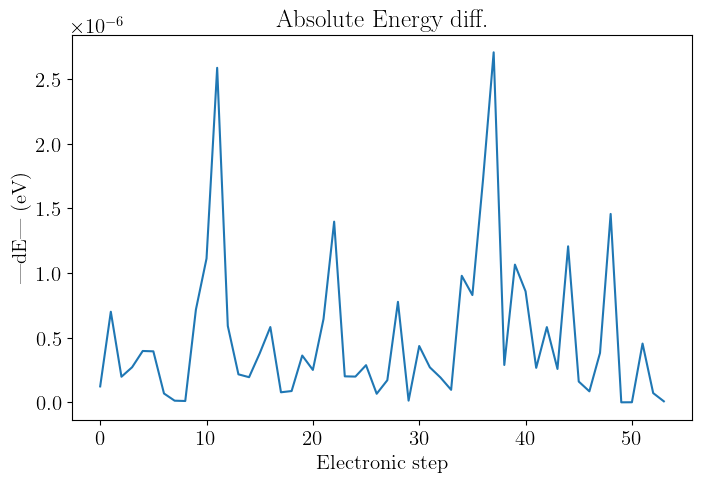

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	3	-25.56	 	0.0000	 	-81.72297006
     Total free E  E without entropy  Free tot E pr FU  E w/o entropy pr FU  \
-50    -81.702202         -81.702202        -20.425551           -20.425551   
-40    -81.832420         -81.832420        -20.458105           -20.458105   
-30    -81.933609         -81.933609        -20.483402           -20.483402   
-20    -82.005907         -82.005907        -20.501477           -20.501477   
-10    -82.049783         -82.049783        -20.512446           -20.512446   
 10    -82.051481         -82.051481        -20.512870           -20.512870   
 20    -82.009507         -82.009507        -20.502377           -20.502377   
 30    -81.940174         -81.940174        -20.485044           -20.485044   
 40    -81.844201         -81.844201        -20.461050           -20.461050   
 50    -81.722970         -81.722970        -20.430743           -20.430743   

     Free tot E pr ion  E w/o entropy pr io

In [16]:
pathzeroc = f"{homedir}/nn9301k/CuFeS2/pbesol/pbesol/dftu4/7/A111"
[A111_en0, exewe] = read_outcar(f'{pathzeroc}/OUTCAR')
vol0 = Structure.from_file(f"{pathzeroc}/CONTCAR").lattice.volume
print(A111_en0)

os.chdir(f"{homedir}/nn9301k/CuFeS2/pbesol/pbesol/dftu4/7/A111/acfix")
straindirs = glob.glob('strain*')
strains = np.array([int(s[6:len(s)]) for s in straindirs])
strains.sort()
print(strains)

ionsA = 16
perFormulaU = 4

finishedA = []
latconstsA = {}
energiesA = {}
magmomsA = []
last_stepsA = {}
volumes_acfix = {}

for s in strains:
    print(s)
    os.chdir(f"strain{s}")
    volumes_acfix.update({s: Structure.from_file('CONTCAR').lattice.volume})
    logs = glob.glob('slurm*')
    indices = slurmlogindices(logs)
    if len(indices) > 1:
        last_index = indices[len(indices) - 1]
    else:
        last_index = indices[0]
        
    print(f'Last job was {last_index}')
    dEfile = 'OSZICAR'
    try:
        dE = read_dE(dEfile)
        print(f'dE reached {dE}')
        [f, ewe] = read_outcar(f'OUTCAR')
        latconstsA.update({s: get_lattice_consts(f'CONTCAR')})
        print(check_slurmfile(f'slurm-{last_index}.out'))
        last_ionic_steps = plot_convergence(f'OSZICAR')
        last_stepsA.update({s: last_ionic_steps})
        maxforceselective(f'OUTCAR')

        energiesA.update({s: {'Total free E': f, 'E without entropy': ewe,
                            'Free tot E pr FU': f/(ionsA/perFormulaU), 
                            'E w/o entropy pr FU': ewe/(ionsA/perFormulaU),
                            'Free tot E pr ion': f/ionsA,
                            'E w/o entropy pr ion': ewe/ionsA}})
        finishedA.append(s)
    except Exception as exc:
        print(exc)
    os.chdir('..')
    
finishedAac = np.array(finishedA)/10
freeFUAac = np.array([energiesA[k]['Free tot E pr FU'] for k in energiesA.keys()])
eweFUAac = np.array([energiesA[k]['E w/o entropy pr FU'] for k in energiesA.keys()])

freeAac = np.array([energiesA[k]['Free tot E pr ion'] for k in energiesA.keys()])
eweAac = np.array([energiesA[k]['E w/o entropy pr ion'] for k in energiesA.keys()])

# In table form
print(pd.DataFrame(data=energiesA).T)

In [17]:
Aen0_fu = A111_en0/4
volumes = [volumes_acfix[k] for k in volumes_acfix.keys()]
volumes_acfix_x = np.array(volumes[0:5] + [vol0] + volumes[5:10])/vol0
ediff = list(freeFUAac - Aen0_fu)
ediff_acfix = ediff[0:5] + [0] + ediff[5:10]

[-50 -40 -30 -20 -10   0  10  20  30  40  50]
-50
Last job was 4531254
dE reached -9.939e-09

ionic steps taken: [1]
ionic steps, total: 1


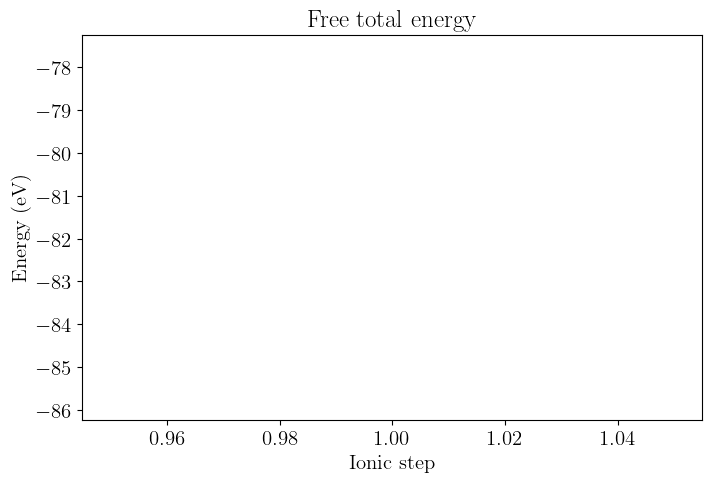

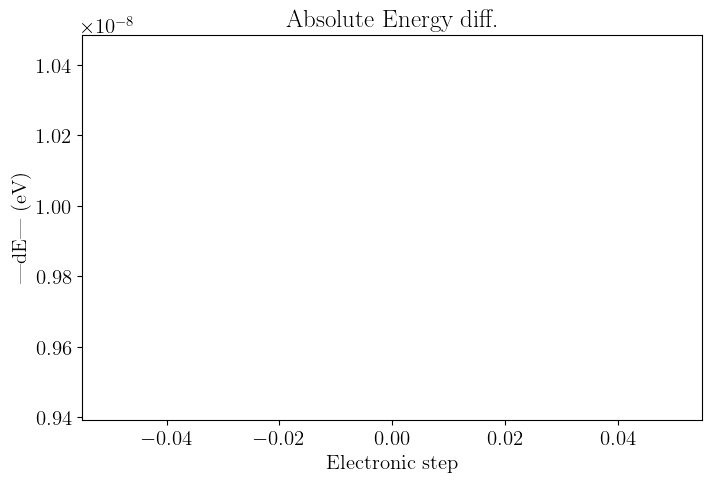

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00000	  	1	23.20	 	0.0000	 	-81.73723337
-40
Last job was 4531255
dE reached -2.7176e-09

ionic steps taken: [1]
ionic steps, total: 1


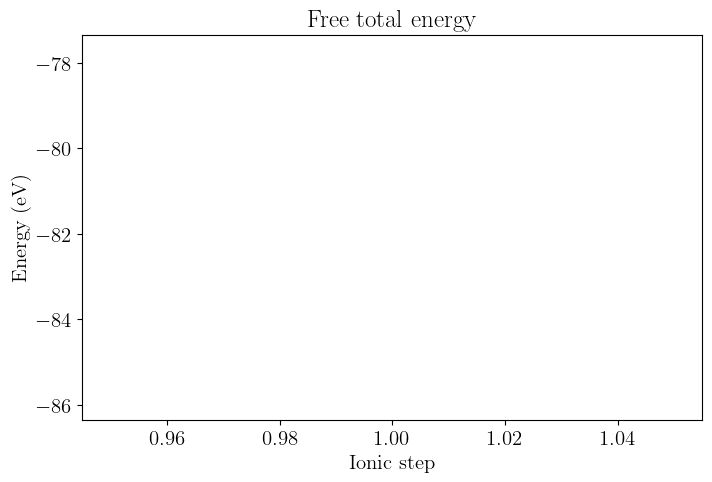

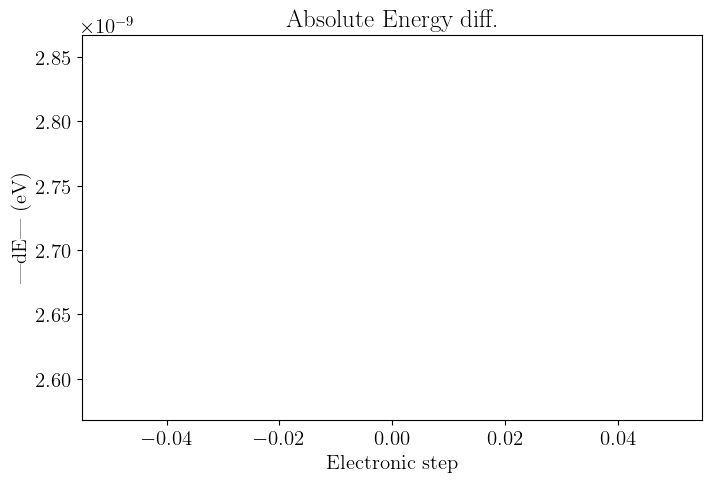

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00000	  	1	18.80	 	0.0000	 	-81.85328282
-30
Last job was 4531256
dE reached 5.0204e-09

ionic steps taken: [1]
ionic steps, total: 1


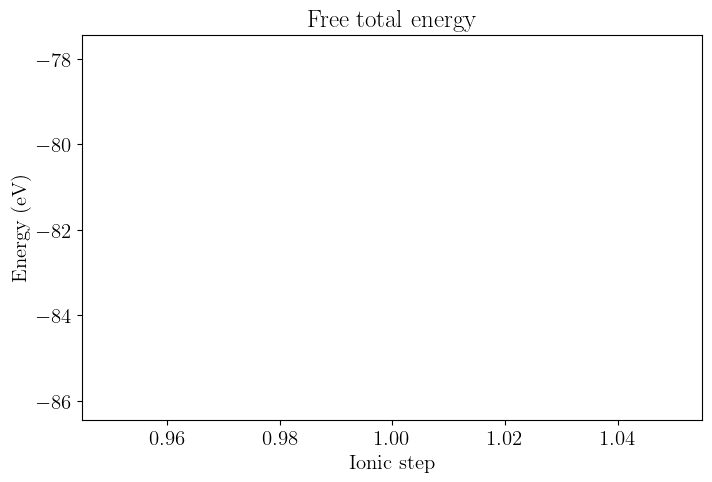

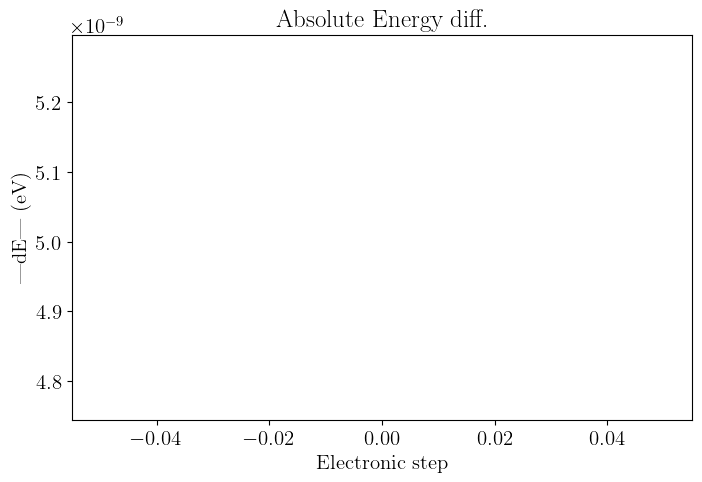

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	1	14.30	 	0.0000	 	-81.94419940
-20
Last job was 4531257
dE reached 7.1759e-09

ionic steps taken: [1]
ionic steps, total: 1


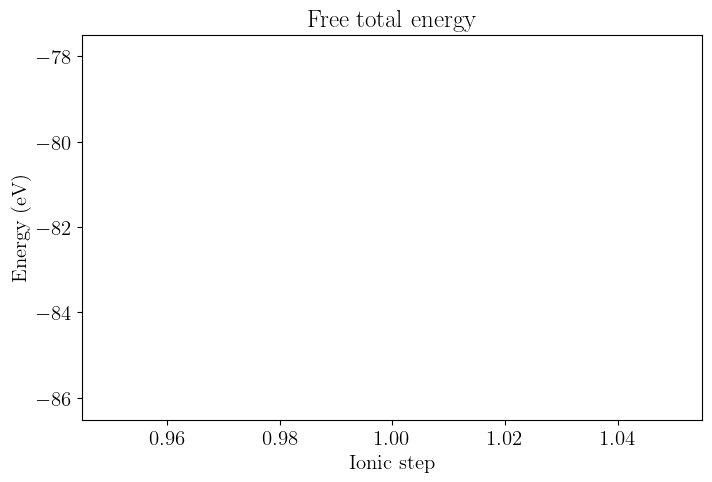

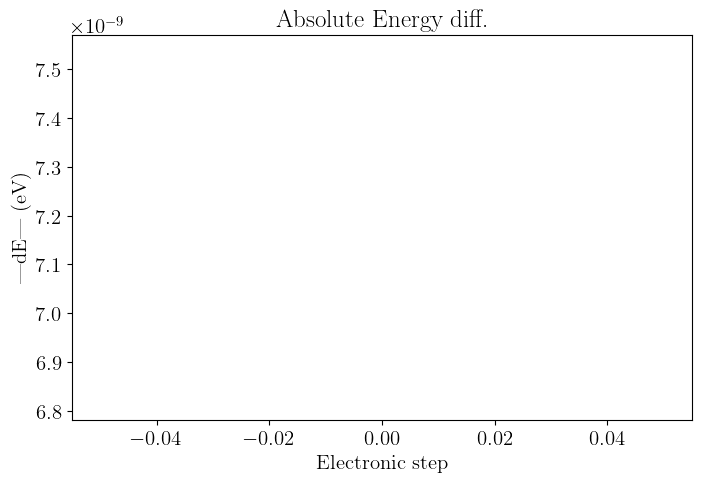

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	1	9.74	 	0.0000	 	-82.01037288
-10
Last job was 4531258
dE reached -6.5902e-09

ionic steps taken: [1]
ionic steps, total: 1


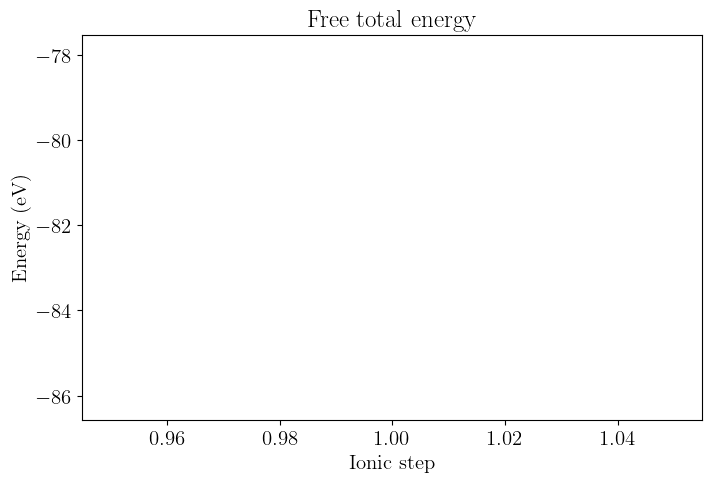

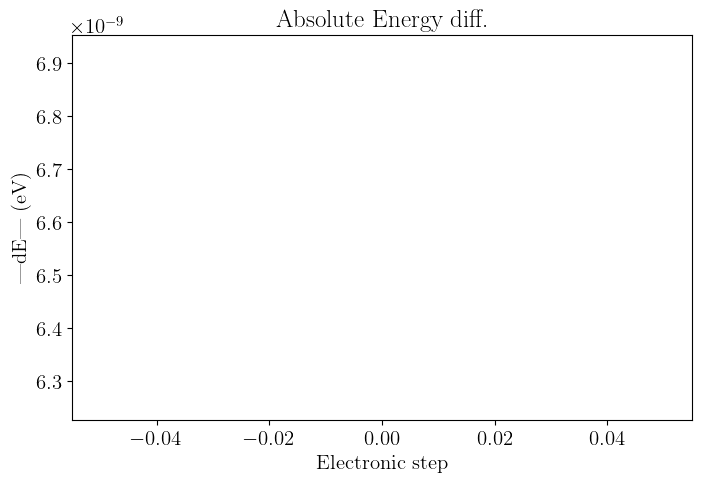

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	1	4.95	 	0.0000	 	-82.05103632
0
Last job was 4531259
dE reached -8.3728e-09

ionic steps taken: [1]
ionic steps, total: 1


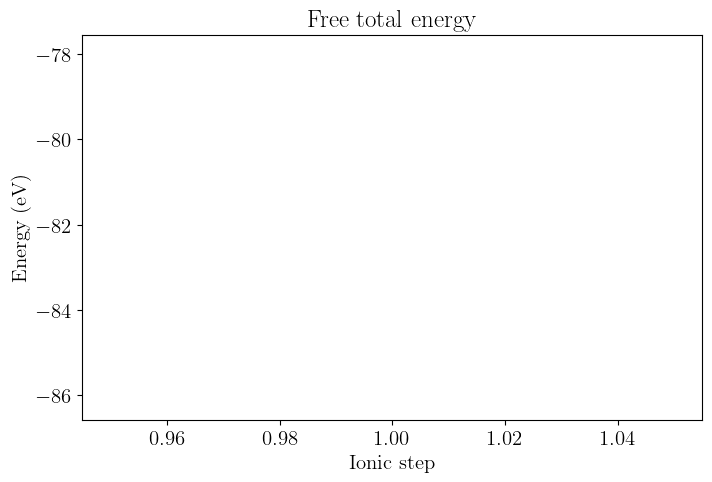

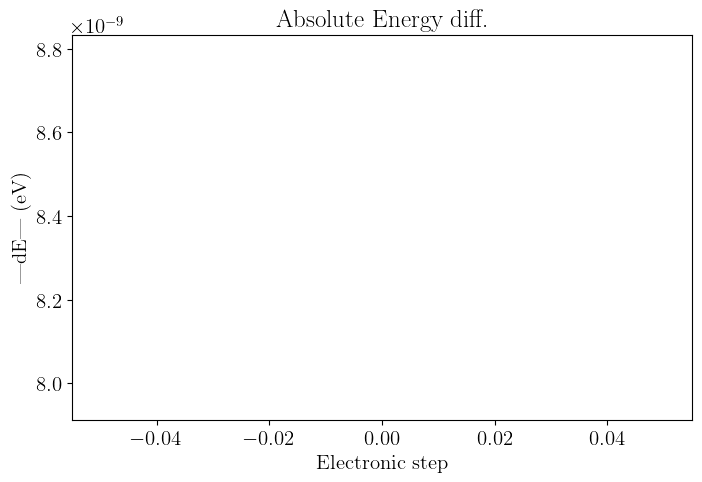

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	1	-0.00	 	0.0000	 	-82.06499862
10
Last job was 4531260
dE reached -3.7944e-09

ionic steps taken: [1]
ionic steps, total: 1


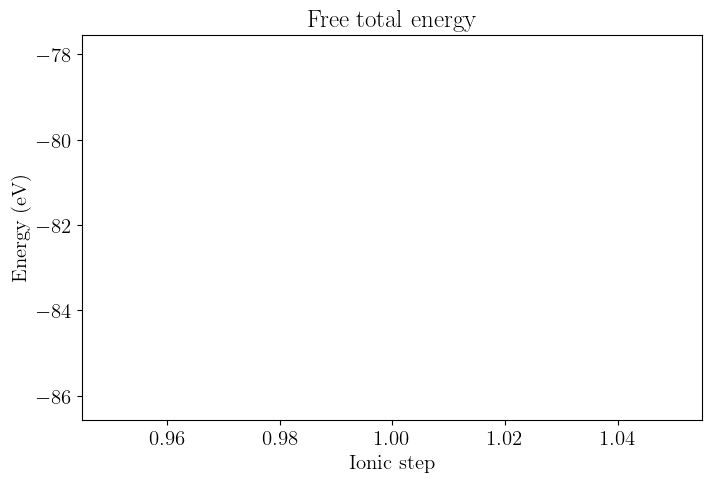

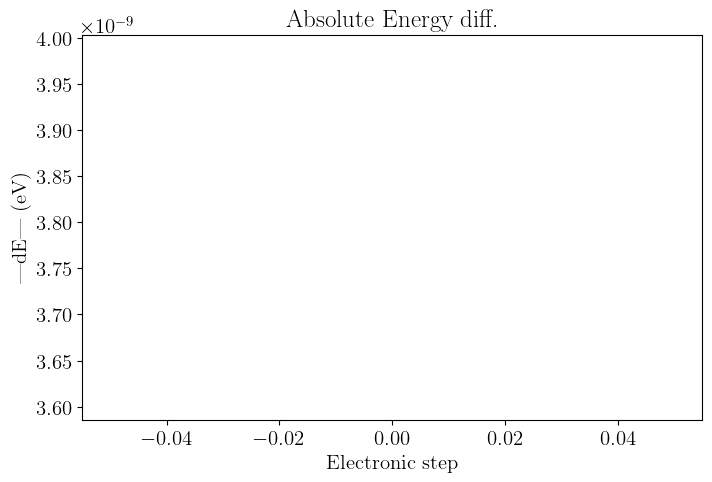

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	1	-5.04	 	0.0000	 	-82.05199735
20
Last job was 4531261
dE reached -8.3182e-09

ionic steps taken: [1]
ionic steps, total: 1


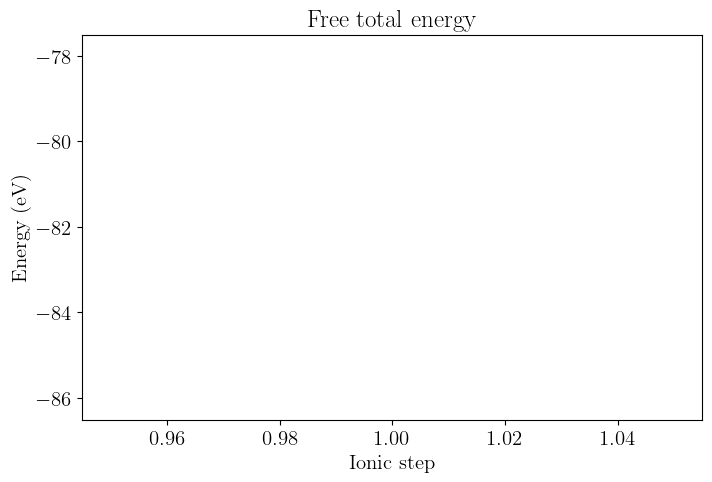

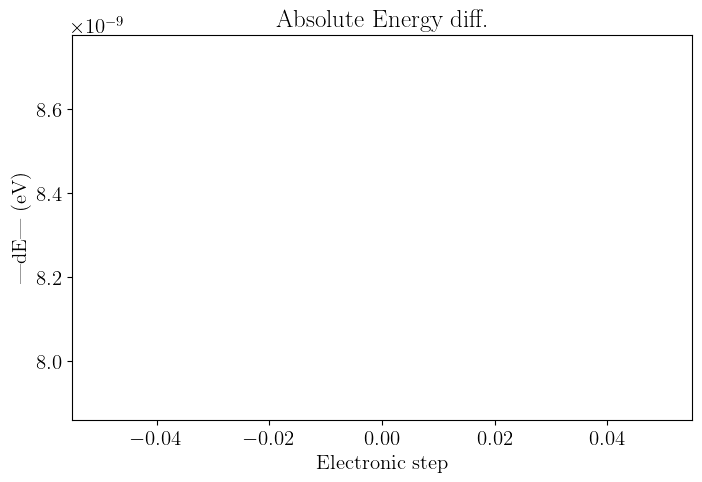

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00000	  	1	-10.06	 	0.0000	 	-82.01219348
30
Last job was 4531262
dE reached -8.9658e-09

ionic steps taken: [1]
ionic steps, total: 1


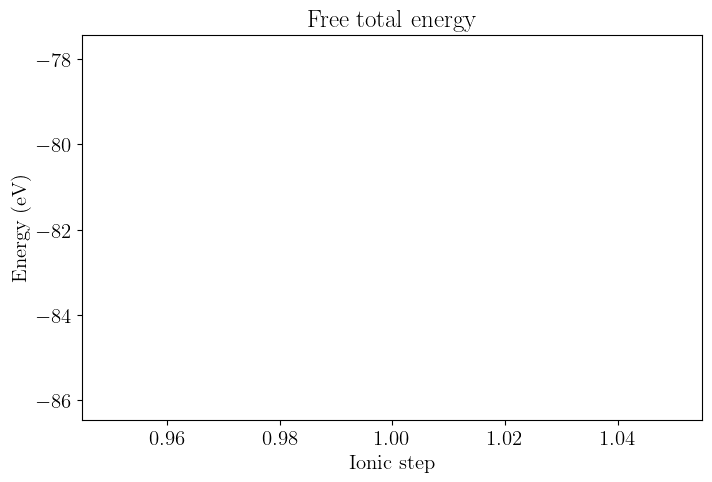

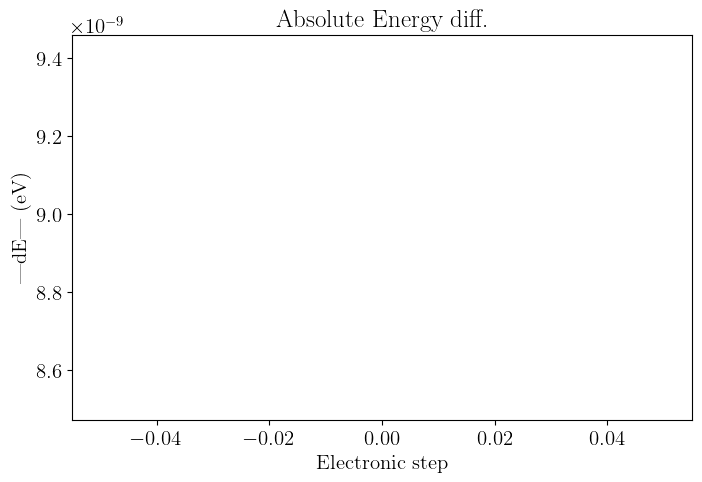

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	1	-15.09	 	0.0000	 	-81.94570922
40
Last job was 4531263
dE reached 2.0009e-11

ionic steps taken: [1]
ionic steps, total: 1


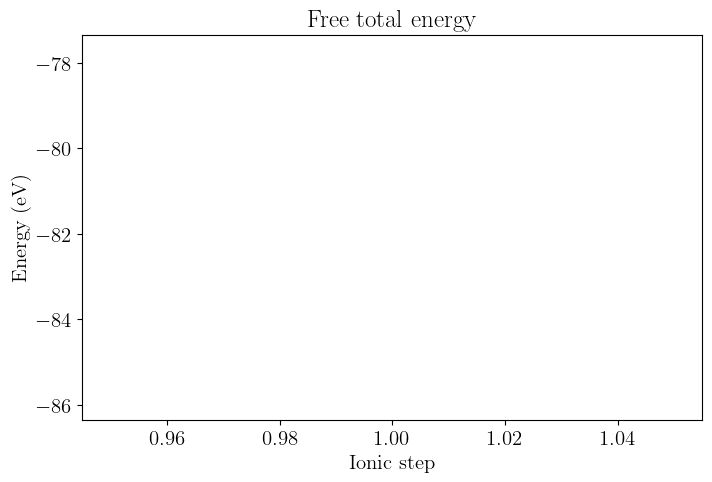

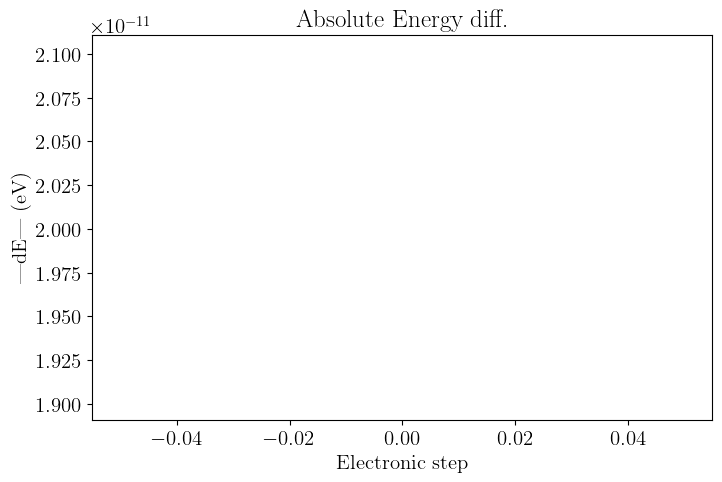

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00000	  	1	-20.10	 	0.0000	 	-81.85303639
50
Last job was 4531264
dE reached 7.7307e-10

ionic steps taken: [1]
ionic steps, total: 1


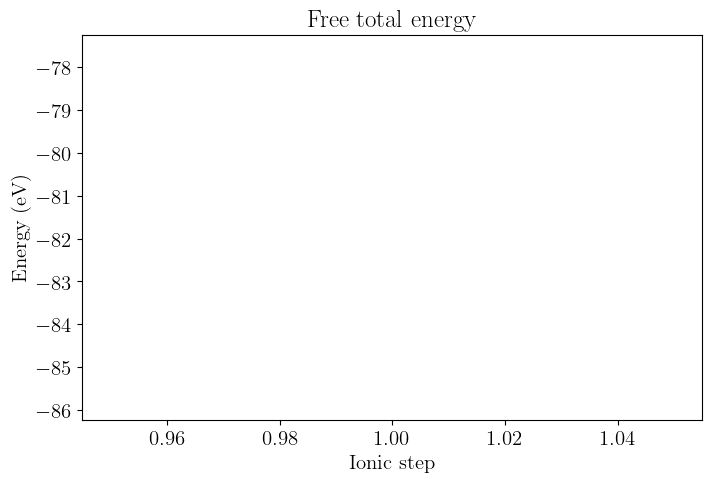

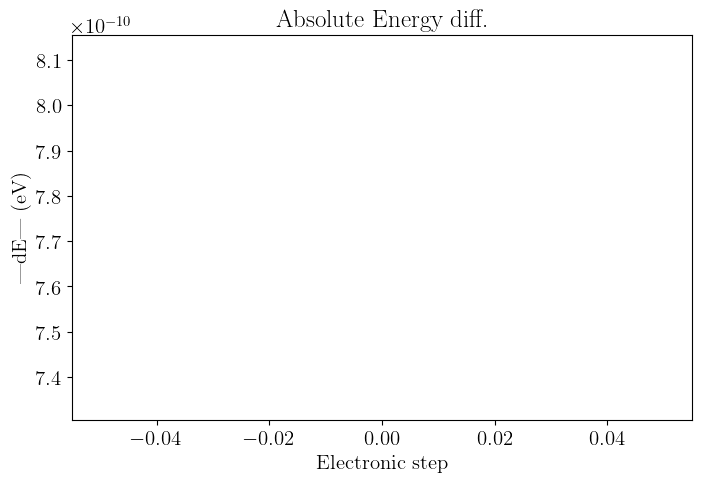

 	Maxforce	atom#	Pressure	Maxdrift	TOTEN
 	0.00001	  	1	-25.11	 	0.0000	 	-81.73483323
     Total free E  E without entropy  Free tot E pr FU  E w/o entropy pr FU  \
-50    -81.737233         -81.737233        -20.434308           -20.434308   
-40    -81.853283         -81.853283        -20.463321           -20.463321   
-30    -81.944199         -81.944199        -20.486050           -20.486050   
-20    -82.010373         -82.010373        -20.502593           -20.502593   
-10    -82.051036         -82.051036        -20.512759           -20.512759   
 0     -82.064999         -82.064999        -20.516250           -20.516250   
 10    -82.051997         -82.051997        -20.512999           -20.512999   
 20    -82.012193         -82.012193        -20.503048           -20.503048   
 30    -81.945709         -81.945709        -20.486427           -20.486427   
 40    -81.853036         -81.853036        -20.463259           -20.463259   
 50    -81.734833         -81.734833        

In [18]:
os.chdir(f"{homedir}/nn9301k/CuFeS2/pbesol/pbesol/dftu4/7/A111/abfix")
straindirs = glob.glob('strain*')
strains = np.array([int(s[6:len(s)]) for s in straindirs])
strains.sort()
print(strains)

ionsA = 16
perFormulaU = 4

finishedA = []
latconstsA = {}
energiesA = {}
magmomsA = []
last_stepsA = {}
volumes_abfix = {}

for s in strains:
    print(s)
    os.chdir(f"strain{s}")
    volumes_abfix.update({s: Structure.from_file('CONTCAR').lattice.volume})
    logs = glob.glob('slurm*')
    indices = slurmlogindices(logs)
    if len(indices) > 1:
        last_index = indices[len(indices) - 1]
    else:
        last_index = indices[0]
        
    print(f'Last job was {last_index}')
    dEfile = 'OSZICAR'
    try:
        dE = read_dE(dEfile)
        print(f'dE reached {dE}')
        [f, ewe] = read_outcar(f'OUTCAR')
        latconstsA.update({s: get_lattice_consts(f'CONTCAR')})
        print(check_slurmfile(f'slurm-{last_index}.out'))
        last_ionic_steps = plot_convergence(f'OSZICAR')
        last_stepsA.update({s: last_ionic_steps})
        maxforceselective(f'OUTCAR')
        
        energiesA.update({s: {'Total free E': f, 'E without entropy': ewe,
                            'Free tot E pr FU': f/(ionsA/perFormulaU), 
                            'E w/o entropy pr FU': ewe/(ionsA/perFormulaU),
                            'Free tot E pr ion': f/ionsA,
                            'E w/o entropy pr ion': ewe/ionsA}})
        finishedA.append(s)
    except Exception as exc:
        print(exc)
    os.chdir('..')
    
finishedAab = np.array(finishedA)/10
freeFUAab = np.array([energiesA[k]['Free tot E pr FU'] for k in energiesA.keys()])
eweFUAab = np.array([energiesA[k]['E w/o entropy pr FU'] for k in energiesA.keys()])

freeAab = np.array([energiesA[k]['Free tot E pr ion'] for k in energiesA.keys()])
eweAab = np.array([energiesA[k]['E w/o entropy pr ion'] for k in energiesA.keys()])

# In table form
print(pd.DataFrame(data=energiesA).T)

In [19]:
Aen0_fu = A111_en0/4
volumes = [volumes_abfix[k] for k in volumes_abfix.keys()]
volumes_abfix_x = np.array(volumes)/vol0
ediff_abfix = list(freeFUAab - Aen0_fu)

In [21]:
vol221_0 = 1151.2831113542254 # supercell
en221_0 = -328.1266169 # supercell

volumes_acshear = np.array([vol221_0, 1151.1387463158787, 1150.7030561250594, 1150.017153124164, 1148.9995016658672, 
                   1147.6256423585314, 1146.0637100072, 1144.2739677985035, 1142.2456457798999, 
                  1139.908163636958, 1137.3353827438843])/vol221_0 # per supercell

en_acshear = (np.array([en221_0, -328.09456834, -327.99404789, -327.82796818, -327.60200726, -327.30742993, -326.94575461, 
                       -326.51749343, -326.02295626, -325.45980177, -324.83118224]) - en221_0)/16 # per f.u.

volumes_abshear = np.array([vol221_0, 1150.9097105671074, 1150.2817303853406, 1149.5488222391182, 
                            1148.5359354170434, 1147.3123198284966, 1145.8804451708884, 1144.22590778838,
                            1142.376374249948, 1140.2638752985279, 1138.156878425784])/vol221_0

en_abshear = (np.array([en221_0, -328.1156553, -327.99387837, -327.8312549, -327.60321609, -327.3093688, 
                       -326.94807201, -326.51925767, -326.02147889, -325.45236322, -324.81231141]) - en221_0)/16        

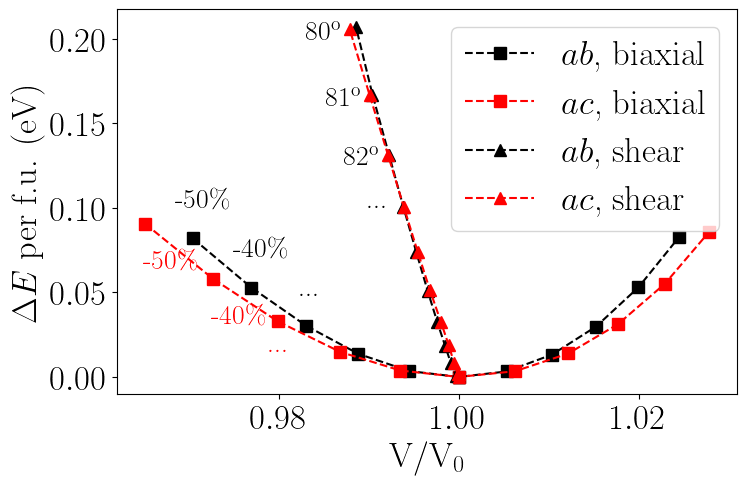

In [22]:
### Plotting energy vs strain
fig, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
        "font.weight": "normal",
        "font.style": "normal",
    "mathtext.default": "regular"
    })

mrkrsz = 8
ax.plot(volumes_abfix_x, ediff_abfix, 'sk--', markersize = mrkrsz, label='$ab$, biaxial')
ax.plot(volumes_acfix_x, ediff_acfix, 'sr--', markersize = mrkrsz, label='$ac$, biaxial')
ax.plot(volumes_abshear, en_abshear, '^k--', markersize = mrkrsz, label='$ab$, shear')
ax.plot(volumes_acshear, en_acshear, '^r--', markersize = mrkrsz, label='$ac$, shear')

ax.ticklabel_format(useOffset=False)
plt.ylabel('$\Delta E$ per f.u. (eV)')
plt.xlabel('V/V$_0$')
ax.tick_params(labelbottom=True)
plt.legend()

offsetx = 0.002
offsety = 0.018
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
        "font.weight": "normal",
        "font.style": "normal",
    "mathtext.default": "regular"
    })
for i, s in enumerate(strains[0:2]):
    ax.annotate(f"{s}\%", (volumes_abfix_x[i], ediff_abfix[i]), 
               (volumes_abfix_x[i] - offsetx, ediff_abfix[i] + offsety))
    
    ax.annotate(f"{s}\%", (volumes_acfix_x[i], ediff_acfix[i]),
               (volumes_acfix_x[i] - offsetx*0.1, ediff_acfix[i] - offsety*3/2), color="red")

ax.annotate("...", (volumes_abfix_x[i+1], ediff_abfix[i+1]), 
            (volumes_abfix_x[i+1] - offsetx*0.35, ediff_abfix[i+1] + offsety))
ax.annotate("...", (volumes_acfix_x[i+1], ediff_acfix[i+1]),
            (volumes_acfix_x[i+1] - offsetx/2, ediff_acfix[i+1] - offsety), color="red")

for i, a in enumerate(range(80, 83)):
    ax.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_acshear)[i], np.flip(en_acshear)[i]), 
               (np.flip(volumes_acshear)[i] - offsetx*2.5, np.flip(en_acshear)[i]-offsety/3))
    
ax.annotate("...", (np.flip(volumes_acshear)[i+1], np.flip(en_acshear)[i+1]), 
               (np.flip(volumes_acshear[i+1]) - offsetx*4.5, np.flip(en_acshear)[i+1]))

#plt.savefig('energies_cufes2_afm_fm.pdf', format="pdf", bbox_inches="tight")
plt.rcParams.update({'font.size': 25})
plt.show()

In [69]:
magmoms = []
for i in [-50, -40, -30, -20, -10]:
    m = abs(Outcar(f'{pathzeroc}/acfix/strain{i}/OUTCAR').magnetization[15]['tot'][2])
    magmoms.append(m)

magmoms.append(abs(Outcar(f'{pathzeroc}/OUTCAR').magnetization[15]['tot'][2]))

for i in [10, 20, 30, 40, 50]:
    m = abs(Outcar(f'{pathzeroc}/acfix/strain{i}/OUTCAR').magnetization[15]['tot'][2])
    magmoms.append(m)

magmoms

[3.701, 3.711, 3.719, 3.728, 3.735, 3.743, 3.75, 3.757, 3.764, 3.771, 3.778]

In [68]:
magmomsab = []
for i in [-50, -40, -30, -20, -10]:
    m = abs(Outcar(f'{pathzeroc}/abfix/strain{i}/OUTCAR').magnetization[15]['tot'][2])
    magmomsab.append(m)

magmomsab.append(abs(Outcar(f'{pathzeroc}/OUTCAR').magnetization[15]['tot'][2]))

for i in [10, 20, 30, 40, 50]:
    m = abs(Outcar(f'{pathzeroc}/abfix/strain{i}/OUTCAR').magnetization[15]['tot'][2])
    magmomsab.append(m)

magmomsab

[3.724, 3.729, 3.733, 3.736, 3.739, 3.743, 3.747, 3.751, 3.755, 3.76, 3.765]

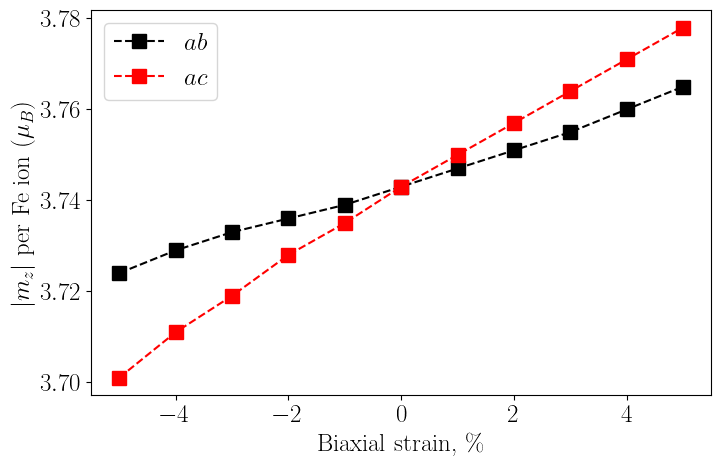

In [72]:
fig, (ax1) = plt.subplots(figsize=(8,5))

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
        "font.weight": "normal",
        "font.style": "normal",
    "mathtext.default": "regular"
    })

strains = list(range(-5,6))
ax1.plot(strains, magmomsab, 'sk--', markersize=10, label="$ab$")
ax1.plot(strains, magmoms, 'rs--', markersize=10, label="$ac$")
ax1.set_ylabel('$|m_z|$ per Fe ion ($\mu_B$)')
plt.xticks([-4, -2, 0, 2, 4])
ax1.set_xlabel('Biaxial strain, \%')
plt.legend()
#plt.savefig(f'magmomsabfixz.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [23]:
struct0 = Structure.from_file(f'{pathzeroc}/CONTCAR')
latb0 = struct0.lattice.b
vol0 = struct0.lattice.volume

In [24]:
latsb0 = []
volumes_ac = []
for i in [-50, -40, -30, -20, -10]:
    struct = Structure.from_file(f'{pathzeroc}/acfix/strain{i}/CONTCAR')
    volumes_ac.append(struct.lattice.volume)
    latsb0.append(struct.lattice.b)

volumes_ac.append(struct0.lattice.volume)
latsb0.append(struct0.lattice.b)

for i in [10, 20, 30, 40, 50]:
    struct = Structure.from_file(f'{pathzeroc}/acfix/strain{i}/CONTCAR')
    volumes_ac.append(struct.lattice.volume)
    latsb0.append(struct.lattice.b)

print(volumes_ac)
print(latsb0)

[277.8142709844055, 279.98277003484907, 282.0635715218241, 284.05934772187703, 285.97874755406986, 287.84069224364015, 289.6441907715863, 291.34485865830123, 292.9320577919974, 294.4354862545261, 295.8317793526992]
[5.62393923677274, 5.550372350534233, 5.476925220818812, 5.403687348121492, 5.330852299448225, 5.258785655520129, 5.187467085512325, 5.116114955129116, 5.044588345490658, 4.9734384990282186, 4.902295733336563]


In [25]:
latsc0 = []
volumes_ab = []
for i in [-50, -40, -30, -20, -10]:
    struct = Structure.from_file(f'{pathzeroc}/abfix/strain{i}/CONTCAR')
    volumes_ab.append(struct.lattice.volume)
    latsc0.append(struct.lattice.c)

volumes_ab.append(struct0.lattice.volume)
latsc0.append(struct0.lattice.c)

for i in [10, 20, 30, 40, 50]:
    struct = Structure.from_file(f'{pathzeroc}/abfix/strain{i}/CONTCAR')
    volumes_ab.append(struct.lattice.volume)
    latsc0.append(struct.lattice.c)

print(volumes_ab)
print(latsc0)

[279.34653485407546, 281.2105142349369, 282.9745135862213, 284.6348199151217, 286.25830557877487, 287.84069224364015, 289.37493315028445, 290.82331190836845, 292.23366276510006, 293.58556308293294, 294.8765423318107]
[11.192449375314391, 11.033623214837931, 10.875091364841866, 10.716795325238484, 10.561285132460169, 10.4083347443068, 10.257634523194607, 10.107830094247532, 9.960585156059487, 9.815153087533105, 9.671429893690487]


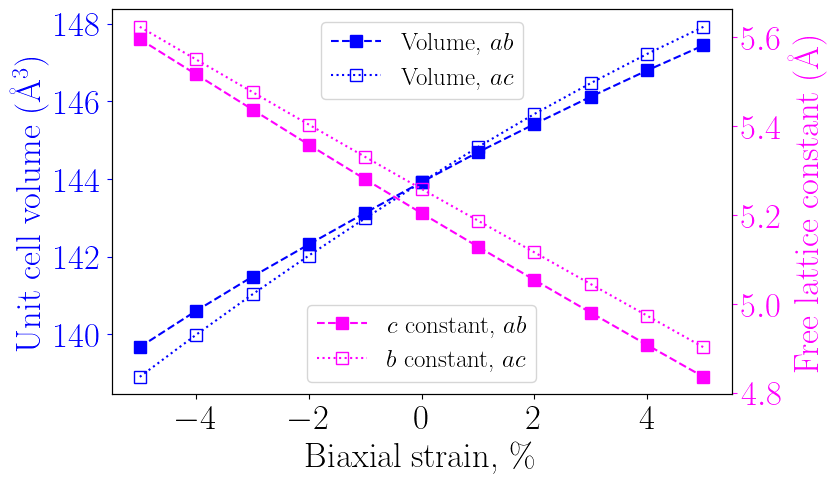

In [26]:
fig, (ax1) = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
        "font.weight": "normal",
        "font.style": "normal",
    "mathtext.default": "regular"
    })

mrksz = 8
strains = list(range(-5,6))
clr1 = "blue"
clr2 = "magenta"
ax1.plot(strains, np.array(volumes_ab)/2, 's--', color= clr1, markersize=mrksz, label="Volume, $ab$")
ax1.plot(strains, np.array(volumes_ac)/2, 's:', color= clr1, markersize=mrksz, markerfacecolor='none', label="Volume, $ac$")
ax2.plot(strains, np.array(latsc0)/2, 's--', color=clr2, markersize=mrksz, label="$c$ constant, $ab$")
ax2.plot(strains, latsb0, 's:', color=clr2, markersize=mrksz, markerfacecolor='none', label="$b$ constant, $ac$")

ax1.set_ylabel('Unit cell volume (Å$^3$)', color=clr1)
ax2.set_ylabel('Free lattice constant (Å)', color=clr2)
ax1.tick_params(axis='y', colors=clr1)
#ax1.set_yticks([280, 285, 290, 295])
ax2.tick_params(axis='y', colors=clr2)
plt.xticks([-4, -2, 0, 2, 4])
ax1.set_xlabel('Biaxial strain, \%')
ax1.legend(loc="upper center")#, bbox_to_anchor=(1.0, 1), ncol= 1, prop={'size': 15})
ax2.legend(loc="lower center")#, bbox_to_anchor=(1.0, 1), ncol= 1, prop={'size': 15})
plt.savefig(f'{homedir}/nn9301k/volume_lat_param_abfix.pdf', format="pdf", bbox_inches="tight")
plt.show()

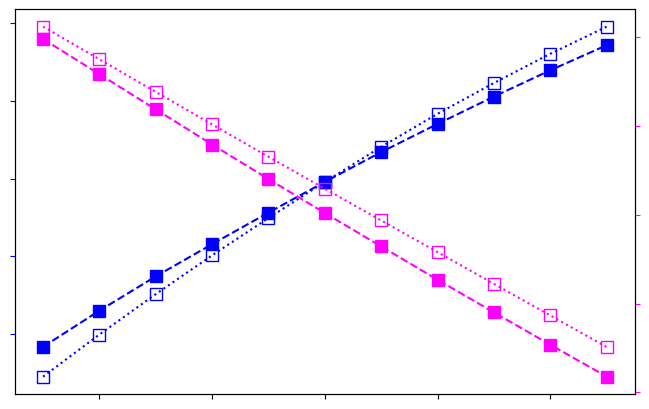

In [354]:
fig, (ax1) = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
        "font.weight": "normal",
        "font.style": "normal",
    "mathtext.default": "regular"
    })

mrksz = 8
strains = list(range(-5,6))
clr1 = "blue"
clr2 = "magenta"
ax1.plot(strains, np.array(volumes_ab)/2, 's--', color= clr1, markersize=mrksz, label="Volume, $ab$")
ax1.plot(strains, np.array(volumes_ac)/2, 's:', color= clr1, markersize=mrksz, markerfacecolor='none', label="Volume, $ac$")
ax2.plot(strains, np.array(latsc0)/2, 's--', color=clr2, markersize=mrksz, label="$c$ constant, $ab$")
ax2.plot(strains, latsb0, 's:', color=clr2, markersize=mrksz, markerfacecolor='none', label="$b$ constant, $ac$")

#ax1.set_ylabel('Unit cell volume (Å$^3$)', color=clr1)
#ax2.set_ylabel('Free lattice constant (Å)', color=clr2)
ax1.tick_params(axis='y', colors=clr1)
#ax1.set_yticks([280, 285, 290, 295])
ax2.tick_params(axis='y', colors=clr2)
plt.xticks([-4, -2, 0, 2, 4])
ax1.xaxis.set_tick_params(labelbottom=False)
ax1.yaxis.set_tick_params(labelleft=False)
ax2.yaxis.set_tick_params(labelright=False)

#ax1.set_xlabel('Biaxial strain, \%')
#ax1.legend(loc="upper center")#, bbox_to_anchor=(1.0, 1), ncol= 1, prop={'size': 15})
#ax2.legend(loc="lower center")#, bbox_to_anchor=(1.0, 1), ncol= 1, prop={'size': 15})
plt.savefig(f'{homedir}/nn9301k/volume_lat_param_abfix_nolegend.pdf', format="pdf", bbox_inches="tight")
plt.show()

In [87]:
for i in range(len(latsc0) - 1):
    print(100*(latsc0[i+1] - latsc0[i])/latsc0[i])

-1.41904738766798
-1.4368068123159419
-1.4555835375796282
-1.4510885769375739
-1.448217581809961
-1.4478802307412615
-1.460418857859835
-1.4567413264281495
-1.4600755502593064
-1.4642990543384455


In [88]:
for i in range(len(latsb0) - 1):
    print(100*(latsb0[i+1] - latsb0[i])/latsb0[i])

-1.3081024374780215
-1.323282927285985
-1.3372078263717886
-1.3478768104262655
-1.3518784592016286
-1.3561794429278824
-1.3754714816886846
-1.3980649431410666
-1.4104192768482378
-1.4304543165770882


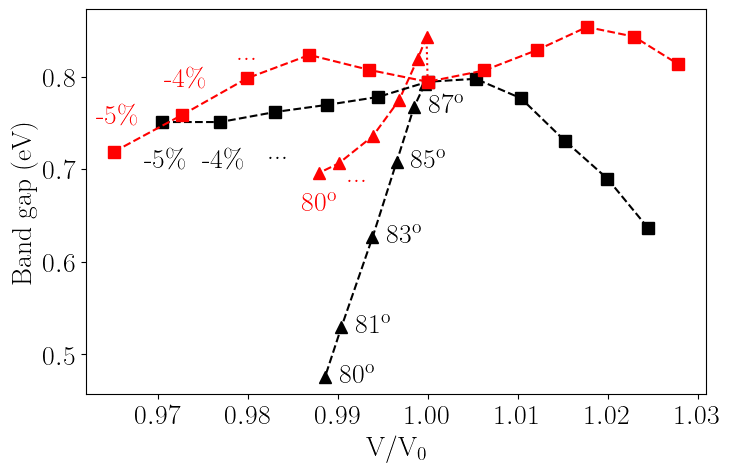

In [303]:
fig, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
        "font.weight": "normal",
        "font.style": "normal",
    "mathtext.default": "regular"
    })

gap_ab_biax = [0.7511, 0.7511, 0.7620, 0.7697, 0.7782, 0.7946, 0.7978, 0.7768, 0.7306, 0.6900, 0.6370]
gap_ac_biax = [0.7190, 0.7586, 0.7983, 0.8236, 0.8074, 0.7946, 0.8068, 0.8290, 0.8538, 0.8434, 0.8140]

gap_ab_shear = [0.7918, 0.7675, 0.7079, 0.6264, 0.5296, 0.4756]
gap_ac_shear = [0.8431, 0.8196, 0.7747, 0.7359, 0.7064, 0.6959]

volumes_abshear = np.array([1150.91, 1149.55, 1147.31, 1144.23, 1140.26, 1138.16])/vol221_0
volumes_acshear = np.array([1151.14, 1150.02, 1147.63, 1144.27, 1139.91, 1137.34])/vol221_0

mrkrsz = 8
ax.plot(volumes_abshear, gap_ab_shear, 'k^--', markersize=mrkrsz, label="$ab$ shear")
ax.plot(volumes_acshear, gap_ac_shear, 'r^--', markersize=mrkrsz, label="$ac$ shear")
ax.plot(volumes_abfix_x, gap_ab_biax, 'ks--', markersize=mrkrsz, label="$ab$ biax")
ax.plot(volumes_acfix_x, gap_ac_biax, 'rs--', markersize=mrkrsz, label="$ac$ biax")
ax.plot([1.0, volumes_acshear[0]], [0.7946, 0.8431], 'r:')

offsetx = 0.001
offsety = 0.02
plt.rcParams.update({'font.size': 20})

for i, s in enumerate(strains[0:2]):
    ax.annotate(f"{s}\%", (volumes_abfix_x[i], gap_ab_biax[i]), 
               (volumes_abfix_x[i] - offsetx*2, gap_ab_biax[i] - offsety*2.5))
    ax.annotate(f"{s}\%", (volumes_acfix_x[i], gap_ac_biax[i]), 
               (volumes_acfix_x[i] - offsetx*2, gap_ac_biax[i] + offsety*1.5), color="red")
    
ax.annotate("...", (volumes_abfix_x[i+1], gap_ab_biax[i+1]), 
            (volumes_abfix_x[i+1] - offsetx*0.7, gap_ab_biax[i+1] - offsety*2.5))
ax.annotate("...", (volumes_acfix_x[i+1], gap_ac_biax[i+1]), 
            (volumes_acfix_x[i+1] - offsetx, gap_ac_biax[i+1] + offsety*1), color="red")

for i, a in enumerate([80]):
    ax.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_acshear)[i], np.flip(gap_ac_shear)[i]), 
               (np.flip(volumes_acshear)[i] - offsetx*2, np.flip(gap_ac_shear)[i]-offsety*2), color="red")
ax.annotate("...", (np.flip(volumes_acshear)[i+1], np.flip(gap_ac_shear)[i+1]), 
               (np.flip(volumes_acshear)[i+1] + offsetx, np.flip(gap_ac_shear)[i+1]-offsety), color="red")
for i, a in enumerate([80, 81, 83, 85, 87]):
    ax.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_abshear)[i], np.flip(gap_ab_shear)[i]), 
               (np.flip(volumes_abshear)[i] + offsetx*1.5, np.flip(gap_ab_shear)[i]-offsety*0.3))
    
#ax.annotate("...", (np.flip(volumes_abshear)[i+1], np.flip(gap_ab_shear)[i+1]), 
#               (np.flip(volumes_abshear[i+1]) - offsetx, np.flip(gap_ab_shear)[i+1]-offsety*0.1))

ax.set_ylabel("Band gap (eV)")
ax.set_xlabel('V/V$_0$')
#plt.legend()
plt.show()

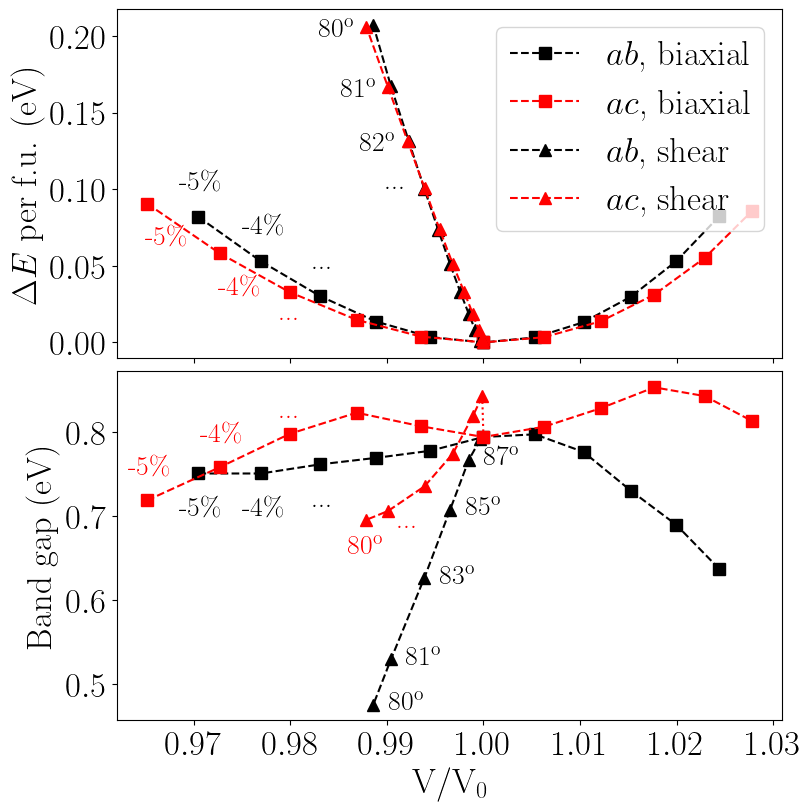

In [337]:
### Plotting energy vs strain
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,8), layout='constrained')
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
        "font.weight": "normal",
        "font.style": "normal",
    "mathtext.default": "regular"
    })

volumes_abshear = np.array([vol221_0, 1150.9097105671074, 1150.2817303853406, 1149.5488222391182, 
                            1148.5359354170434, 1147.3123198284966, 1145.8804451708884, 1144.22590778838,
                            1142.376374249948, 1140.2638752985279, 1138.156878425784])/vol221_0
volumes_acshear = np.array([vol221_0, 1151.1387463158787, 1150.7030561250594, 1150.017153124164, 1148.9995016658672, 
                   1147.6256423585314, 1146.0637100072, 1144.2739677985035, 1142.2456457798999, 
                  1139.908163636958, 1137.3353827438843])/vol221_0 # per supercell

mrkrsz = 8
ax1.plot(volumes_abfix_x, ediff_abfix, 'sk--', markersize = mrkrsz, label='$ab$, biaxial')
ax1.plot(volumes_acfix_x, ediff_acfix, 'sr--', markersize = mrkrsz, label='$ac$, biaxial')
ax1.plot(volumes_abshear, en_abshear, '^k--', markersize = mrkrsz, label='$ab$, shear')
ax1.plot(volumes_acshear, en_acshear, '^r--', markersize = mrkrsz, label='$ac$, shear')

ax1.ticklabel_format(useOffset=False)
ax1.set_ylabel('$\Delta E$ per f.u. (eV)')
ax1.tick_params(labelbottom=True)
ax1.legend()

offsetx = 0.002
offsety = 0.018
plt.rcParams.update({'font.size': 20})

for i, s in enumerate(strains[0:2]):
    ax1.annotate(f"{s}\%", (volumes_abfix_x[i], ediff_abfix[i]), 
               (volumes_abfix_x[i] - offsetx, ediff_abfix[i] + offsety))
    
    ax1.annotate(f"{s}\%", (volumes_acfix_x[i], ediff_acfix[i]),
               (volumes_acfix_x[i] - offsetx*0.1, ediff_acfix[i] - offsety*3/2), color="red")

ax1.annotate("...", (volumes_abfix_x[i+1], ediff_abfix[i+1]), 
            (volumes_abfix_x[i+1] - offsetx*0.35, ediff_abfix[i+1] + offsety))
ax1.annotate("...", (volumes_acfix_x[i+1], ediff_acfix[i+1]),
            (volumes_acfix_x[i+1] - offsetx/2, ediff_acfix[i+1] - offsety), color="red")

for i, a in enumerate(range(80, 83)):
    ax1.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_acshear)[i], np.flip(en_acshear)[i]), 
               (np.flip(volumes_acshear)[i] - offsetx*2.5, np.flip(en_acshear)[i]-offsety/3))
    
ax1.annotate("...", (np.flip(volumes_acshear)[i+1], np.flip(en_acshear)[i+1]), 
               (np.flip(volumes_acshear[i+1]) - offsetx*4.5, np.flip(en_acshear)[i+1]))
ax1.xaxis.set_tick_params(labelbottom=False)

plt.rcParams.update({'font.size': 25})

gap_ab_biax = [0.7511, 0.7511, 0.7620, 0.7697, 0.7782, 0.7946, 0.7978, 0.7768, 0.7306, 0.6900, 0.6370]
gap_ac_biax = [0.7190, 0.7586, 0.7983, 0.8236, 0.8074, 0.7946, 0.8068, 0.8290, 0.8538, 0.8434, 0.8140]

gap_ab_shear = [0.7918, 0.7675, 0.7079, 0.6264, 0.5296, 0.4756]
gap_ac_shear = [0.8431, 0.8196, 0.7747, 0.7359, 0.7064, 0.6959]

volumes_abshear = np.array([1150.91, 1149.55, 1147.31, 1144.23, 1140.26, 1138.16])/vol221_0
volumes_acshear = np.array([1151.14, 1150.02, 1147.63, 1144.27, 1139.91, 1137.34])/vol221_0

mrkrsz = 8
ax2.plot(volumes_abshear, gap_ab_shear, 'k^--', markersize=mrkrsz, label="$ab$ shear")
ax2.plot(volumes_acshear, gap_ac_shear, 'r^--', markersize=mrkrsz, label="$ac$ shear")
ax2.plot(volumes_abfix_x, gap_ab_biax, 'ks--', markersize=mrkrsz, label="$ab$ biax")
ax2.plot(volumes_acfix_x, gap_ac_biax, 'rs--', markersize=mrkrsz, label="$ac$ biax")
ax2.plot([1.0, volumes_acshear[0]], [0.7946, 0.8431], 'r:')
ax2.set_ylabel("Band gap (eV)")
ax2.set_xlabel('V/V$_0$')
fig.subplots_adjust(wspace=0)

offsetx = 0.001
offsety = 0.02
plt.rcParams.update({'font.size': 20})

for i, s in enumerate(strains[0:2]):
    ax2.annotate(f"{s}\%", (volumes_abfix_x[i], gap_ab_biax[i]), 
               (volumes_abfix_x[i] - offsetx*2, gap_ab_biax[i] - offsety*2.5))
    ax2.annotate(f"{s}\%", (volumes_acfix_x[i], gap_ac_biax[i]), 
               (volumes_acfix_x[i] - offsetx*2, gap_ac_biax[i] + offsety*1.5), color="red")
    
ax2.annotate("...", (volumes_abfix_x[i+1], gap_ab_biax[i+1]), 
            (volumes_abfix_x[i+1] - offsetx*0.7, gap_ab_biax[i+1] - offsety*2.5))
ax2.annotate("...", (volumes_acfix_x[i+1], gap_ac_biax[i+1]), 
            (volumes_acfix_x[i+1] - offsetx, gap_ac_biax[i+1] + offsety*1), color="red")

for i, a in enumerate([80]):
    ax2.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_acshear)[i], np.flip(gap_ac_shear)[i]), 
               (np.flip(volumes_acshear)[i] - offsetx*2, np.flip(gap_ac_shear)[i]-offsety*2), color="red")
ax2.annotate("...", (np.flip(volumes_acshear)[i+1], np.flip(gap_ac_shear)[i+1]), 
               (np.flip(volumes_acshear)[i+1] + offsetx, np.flip(gap_ac_shear)[i+1]-offsety), color="red")
for i, a in enumerate([80, 81, 83, 85, 87]):
    ax2.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_abshear)[i], np.flip(gap_ab_shear)[i]), 
               (np.flip(volumes_abshear)[i] + offsetx*1.5, np.flip(gap_ab_shear)[i]-offsety*0.3))

#plt.savefig('energies_cufes2_afm_fm.pdf', format="pdf", bbox_inches="tight")
plt.show()

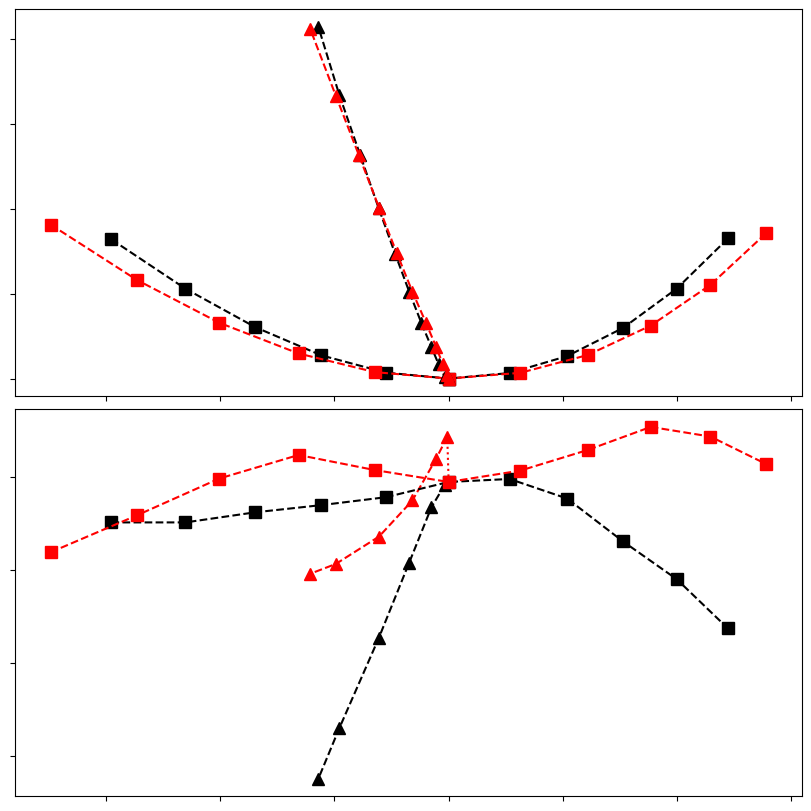

In [350]:
### Plotting energy vs strain
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,8), layout='constrained')
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
        "font.weight": "normal",
        "font.style": "normal",
    "mathtext.default": "regular"
    })

volumes_abshear = np.array([vol221_0, 1150.9097105671074, 1150.2817303853406, 1149.5488222391182, 
                            1148.5359354170434, 1147.3123198284966, 1145.8804451708884, 1144.22590778838,
                            1142.376374249948, 1140.2638752985279, 1138.156878425784])/vol221_0
volumes_acshear = np.array([vol221_0, 1151.1387463158787, 1150.7030561250594, 1150.017153124164, 1148.9995016658672, 
                   1147.6256423585314, 1146.0637100072, 1144.2739677985035, 1142.2456457798999, 
                  1139.908163636958, 1137.3353827438843])/vol221_0 # per supercell

mrkrsz = 8
ax1.plot(volumes_abfix_x, ediff_abfix, 'sk--', markersize = mrkrsz, label='$ab$, biaxial')
ax1.plot(volumes_acfix_x, ediff_acfix, 'sr--', markersize = mrkrsz, label='$ac$, biaxial')
ax1.plot(volumes_abshear, en_abshear, '^k--', markersize = mrkrsz, label='$ab$, shear')
ax1.plot(volumes_acshear, en_acshear, '^r--', markersize = mrkrsz, label='$ac$, shear')

ax1.ticklabel_format(useOffset=False)
#ax1.set_ylabel('$\Delta E$ per f.u. (eV)')
ax1.tick_params(labelbottom=True)
#ax1.legend()

offsetx = 0.002
offsety = 0.018
plt.rcParams.update({'font.size': 20})

#for i, s in enumerate(strains[0:2]):
#    ax1.annotate(f"{s}\%", (volumes_abfix_x[i], ediff_abfix[i]), 
#               (volumes_abfix_x[i] - offsetx, ediff_abfix[i] + offsety))
    
#    ax1.annotate(f"{s}\%", (volumes_acfix_x[i], ediff_acfix[i]),
#               (volumes_acfix_x[i] - offsetx*0.1, ediff_acfix[i] - offsety*3/2), color="red")

#ax1.annotate("...", (volumes_abfix_x[i+1], ediff_abfix[i+1]), 
#            (volumes_abfix_x[i+1] - offsetx*0.35, ediff_abfix[i+1] + offsety))
#ax1.annotate("...", (volumes_acfix_x[i+1], ediff_acfix[i+1]),
#            (volumes_acfix_x[i+1] - offsetx/2, ediff_acfix[i+1] - offsety), color="red")

#for i, a in enumerate(range(80, 83)):
#    ax1.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_acshear)[i], np.flip(en_acshear)[i]), 
#               (np.flip(volumes_acshear)[i] - offsetx*2.5, np.flip(en_acshear)[i]-offsety/3))
    
#ax1.annotate("...", (np.flip(volumes_acshear)[i+1], np.flip(en_acshear)[i+1]), 
#               (np.flip(volumes_acshear[i+1]) - offsetx*4.5, np.flip(en_acshear)[i+1]))
ax1.xaxis.set_tick_params(labelbottom=False)
ax1.yaxis.set_tick_params(labelleft=False)

plt.rcParams.update({'font.size': 25})

gap_ab_biax = [0.7511, 0.7511, 0.7620, 0.7697, 0.7782, 0.7946, 0.7978, 0.7768, 0.7306, 0.6900, 0.6370]
gap_ac_biax = [0.7190, 0.7586, 0.7983, 0.8236, 0.8074, 0.7946, 0.8068, 0.8290, 0.8538, 0.8434, 0.8140]

gap_ab_shear = [0.7918, 0.7675, 0.7079, 0.6264, 0.5296, 0.4756]
gap_ac_shear = [0.8431, 0.8196, 0.7747, 0.7359, 0.7064, 0.6959]

volumes_abshear = np.array([1150.91, 1149.55, 1147.31, 1144.23, 1140.26, 1138.16])/vol221_0
volumes_acshear = np.array([1151.14, 1150.02, 1147.63, 1144.27, 1139.91, 1137.34])/vol221_0

mrkrsz = 8
ax2.plot(volumes_abshear, gap_ab_shear, 'k^--', markersize=mrkrsz, label="$ab$ shear")
ax2.plot(volumes_acshear, gap_ac_shear, 'r^--', markersize=mrkrsz, label="$ac$ shear")
ax2.plot(volumes_abfix_x, gap_ab_biax, 'ks--', markersize=mrkrsz, label="$ab$ biax")
ax2.plot(volumes_acfix_x, gap_ac_biax, 'rs--', markersize=mrkrsz, label="$ac$ biax")
ax2.plot([1.0, volumes_acshear[0]], [0.7946, 0.8431], 'r:')
#ax2.set_ylabel("Band gap (eV)")
#ax2.set_xlabel('V/V$_0$')
fig.subplots_adjust(wspace=0)

ax2.xaxis.set_tick_params(labelbottom=False)
ax2.yaxis.set_tick_params(labelleft=False)

offsetx = 0.001
offsety = 0.02
plt.rcParams.update({'font.size': 20})

#for i, s in enumerate(strains[0:2]):
#    ax2.annotate(f"{s}\%", (volumes_abfix_x[i], gap_ab_biax[i]), 
#               (volumes_abfix_x[i] - offsetx*2, gap_ab_biax[i] - offsety*2.5))
#    ax2.annotate(f"{s}\%", (volumes_acfix_x[i], gap_ac_biax[i]), 
#               (volumes_acfix_x[i] - offsetx*2, gap_ac_biax[i] + offsety*1.5), color="red")
    
#ax2.annotate("...", (volumes_abfix_x[i+1], gap_ab_biax[i+1]), 
#            (volumes_abfix_x[i+1] - offsetx*0.7, gap_ab_biax[i+1] - offsety*2.5))
#ax2.annotate("...", (volumes_acfix_x[i+1], gap_ac_biax[i+1]), 
#            (volumes_acfix_x[i+1] - offsetx, gap_ac_biax[i+1] + offsety*1), color="red")

#for i, a in enumerate([80]):
#    ax2.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_acshear)[i], np.flip(gap_ac_shear)[i]), 
#               (np.flip(volumes_acshear)[i] - offsetx*2, np.flip(gap_ac_shear)[i]-offsety*2), color="red")
#ax2.annotate("...", (np.flip(volumes_acshear)[i+1], np.flip(gap_ac_shear)[i+1]), 
#               (np.flip(volumes_acshear)[i+1] + offsetx, np.flip(gap_ac_shear)[i+1]-offsety), color="red")
#for i, a in enumerate([80, 81, 83, 85, 87]):
#    ax2.annotate(f"{a}"+"\\textsuperscript{o}", (np.flip(volumes_abshear)[i], np.flip(gap_ab_shear)[i]), 
#               (np.flip(volumes_abshear)[i] + offsetx*1.5, np.flip(gap_ab_shear)[i]-offsety*0.3))

plt.savefig(f'{homedir}/nn9301k/energies_cufes2.pdf', format="pdf", bbox_inches="tight")
plt.show()